## Task 1

In this task, we aim to forecast the average number of crimes expected to occur in the upcoming 30 days. To achieve this, we use multiple features:

1. **Historical Crime Data**: The number of crimes reported in the previous 30 days.
  
2. **External Features**: Various external indicators such as temperature, precipitation levels, and unemployment rates, among others, from the last 30 days.

3. **Time Features**: Periodic time features that capture seasonality and trends in the data.

By leveraging these features, we aim to build a predictive model that can accurately estimate the average number of crimes for the next 30 days.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import xgboost as xgb
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, TweedieRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils.optimize import _check_optimize_result
from sklearn.gaussian_process import GaussianProcessRegressor
from sklego.preprocessing import RepeatingBasisFunction
from datetime import datetime, timedelta
from itertools import product
import calendar, holidays
import math
import warnings
warnings.filterwarnings('ignore')

# Set up the plotting style
sns.set(style="whitegrid")

### Crimes Dataset Preprocessing

In [2]:
# Load the dataset
file_path = 'Downloads/Year_to_Date_Community_Safety_Data_.csv'
crimes_df = pd.read_csv(file_path)

crimes_df.head()

X             Y  OBJECTID UniqueIdentifier  \
0  621601.7000  4.854426e+06   1072494    2021_284260_1   
1  618140.7900  4.865006e+06   1073983    2022_319981_1   
2  625581.5800  4.880375e+06   1083148    2022_153903_2   
3  625755.0199  4.880434e+06   1084519    2021_282152_1   
4  626015.0400  4.860797e+06   1084520    2022_269299_1   

                 occ_date                case_type_pubtrans LocationCode  \
0  2021/07/19 12:59:59+00                           Assault    Residence   
1  2022/10/07 21:59:59+00  Theft Under $5000- Election Sign      Outdoor   
2  2022/05/16 09:59:59+00              Mischief To Property     Business   
3  2021/08/18 01:46:00+00              Mischief To Property     Business   
4  2022/08/22 15:00:00+00             Assault with a Weapon    Residence   

    municipality Special_grouping Shooting       occ_id hate_crime  \
0        Vaughan              NaN      NaN  2021_284260        NaN   
1           King              NaN      NaN  2022_319981        NaN   
2      Newmarket              NaN      NaN  2022_153903        NaN   
3      Newmarket              NaN      NaN  2021_282152        NaN   
4  Richmond Hill    Violent Crime      NaN  2022_269299        NaN   

  case_status           occ_type                rep_date  
0      Solved           Assaults  2021/08/19 00:00:00+00  
1      Closed  Theft Under $5000  2022/10/08 00:00:00+00  
2      Solved           Mischief  2022/05/16 00:00:00+00  
3      Solved           Mischief  2021/08/17 00:00:00+00  
4      Solved           Assaults  2022/08/22 00:00:00+00

In [3]:
# Create a mapping of districts to districts
district_mapping = {
    'District 1': ['Aurora', 'East Gwillimbury', 'King', 'Newmarket'],
    'District 2': ['Richmond Hill'],
    'District 3': ['Georgina'],
    'District 4': ['Vaughan'],
    'District 5': ['Markham', 'Whitchurch-Stouffville']
}

# Create a new column in the DataFrame to store the district for each row
crimes_df['district'] = None

# Update the 'district' column based on the municipality
for district, municipalities in district_mapping.items():
    crimes_df.loc[crimes_df['municipality'].isin(municipalities), 'district'] = district

# Convert 'rep_date' to datetime format, remove time zone info, and keep only the date part
crimes_df['date'] = pd.to_datetime(crimes_df['rep_date']).dt.tz_convert(None).dt.normalize()

# Group by 'date' and 'district' to count the number of crimes
crimes_df = crimes_df.groupby(['date', 'district']).size().reset_index(name='Number_of_Crimes')

# Get unique dates and districts
unique_dates = crimes_df['date'].unique()
unique_districts = crimes_df['district'].unique()

# Generate all combinations of unique dates and districts
all_combinations = pd.DataFrame(pd.MultiIndex.from_product([unique_dates, unique_districts], names=['date', 'district']).to_list(), columns=['date', 'district'])

# Merge the new DataFrame with the original DataFrame
crimes_df = pd.merge(all_combinations, crimes_df, on=['date', 'district'], how='left')

# Fill NaN values in 'Number_of_Crimes' with 0
crimes_df['Number_of_Crimes'].fillna(0, inplace=True)

crimes_df.tail()

date    district  Number_of_Crimes
5105 2023-10-19  District 1              15.0
5106 2023-10-19  District 2               5.0
5107 2023-10-19  District 3               4.0
5108 2023-10-19  District 4              10.0
5109 2023-10-19  District 5               7.0

Adding 30 days more to dataset to use it later for future prediction.

In [4]:
# Find the maximum date in the DataFrame
max_date = crimes_df['date'].max()

# Generate a date range for the next 30 days
future_dates = pd.date_range(start=max_date + timedelta(days=1), periods=30, freq='D')

# Generate all combinations of future dates and unique districts
future_combinations = pd.DataFrame(pd.MultiIndex.from_product([future_dates, unique_districts], names=['date', 'district']).to_list(), columns=['date', 'district'])

# Initialize 'Number_of_Crimes' as NaN
future_combinations['Number_of_Crimes'] = None

# Append the new DataFrame to the original DataFrame
crimes_df = pd.concat([crimes_df, future_combinations], ignore_index=True)

crimes_df.tail()

date    district  Number_of_Crimes
5255 2023-11-18  District 1               NaN
5256 2023-11-18  District 2               NaN
5257 2023-11-18  District 3               NaN
5258 2023-11-18  District 4               NaN
5259 2023-11-18  District 5               NaN

In [5]:
# Create separate columns for day, month, and year
crimes_df['day'] = pd.to_datetime(crimes_df['date']).dt.day
crimes_df['month'] = pd.to_datetime(crimes_df['date']).dt.month
crimes_df['year'] = pd.to_datetime(crimes_df['date']).dt.year

crimes_df.head()

date    district  Number_of_Crimes  day  month  year
0 2021-01-01  District 1              15.0    1      1  2021
1 2021-01-01  District 2               8.0    1      1  2021
2 2021-01-01  District 3               5.0    1      1  2021
3 2021-01-01  District 4              16.0    1      1  2021
4 2021-01-01  District 5               6.0    1      1  2021

### Creating Periodic Time Features

This code block is dedicated to generating periodic time features based on the date of each crime incident. These features help capture the seasonality in the data, which is essential for crime forecasting.

1. **Function Definition**: The function `create_periodic_time_features()` takes in a date series and the time period ('year', 'month', or 'week') as inputs.
  
2. **Calculations**: For each date, it calculates how much of the current period (year, month, or week) has passed and maps this onto a unit circle. This way, we get two new features: 'Year_Circle_X' and 'Year_Circle_Y', which are the \( sin \) and \( cos \) values scaled between 0 and 1.

3. **Data Update**: Finally, the `crimes_df` DataFrame is updated with these new features for subsequent modeling tasks.

This approach allows us to model the cyclic nature of crimes over different periods.

In [6]:
# Function to create periodic time features
def create_periodic_time_features(date_series, period='year'):
    x_coordinates = []
    y_coordinates = []
    
    for date in date_series:
        year = date.year

        if period == 'year':
            passed_days = (date - datetime(year, 1, 1)).days + 1
            nr_of_days_per_period = 366 if calendar.isleap(year) else 365

        elif period == 'month':
            passed_days = date.day
            nr_of_days_per_period = calendar.monthrange(year, date.month)[1]

        elif period == 'week':
            passed_days = date.weekday() + 1
            nr_of_days_per_period = 7

        else:
            raise ValueError("Invalid period. Choose from 'year', 'month', 'week'.")

        position_within_period = passed_days / nr_of_days_per_period

        # Scale to 2pi
        alpha = position_within_period * math.pi * 2

        # Calculate sin and cos
        period_circle_x = math.sin(alpha)
        period_circle_y = math.cos(alpha)

        # Scale between 0 and 1
        period_circle_x = (period_circle_x + 1) / 2
        period_circle_y = (period_circle_y + 1) / 2

        x_coordinates.append(period_circle_x)
        y_coordinates.append(period_circle_y)
        
    return x_coordinates, y_coordinates

# Create periodic time features for crimes_df with different periods
crimes_df['Year_Circle_X'], crimes_df['Year_Circle_Y'] = create_periodic_time_features(crimes_df['date'], period='year')
# crimes_df['Month_Circle_X'], crimes_df['Month_Circle_Y'] = create_periodic_time_features(crimes_df['date'], period='month')
# crimes_df['Week_Circle_X'], crimes_df['Week_Circle_Y'] = create_periodic_time_features(crimes_df['date'], period='week')

crimes_df.tail()

date    district  Number_of_Crimes  day  month  year  \
5255 2023-11-18  District 1               NaN   18     11  2023   
5256 2023-11-18  District 2               NaN   18     11  2023   
5257 2023-11-18  District 3               NaN   18     11  2023   
5258 2023-11-18  District 4               NaN   18     11  2023   
5259 2023-11-18  District 5               NaN   18     11  2023   

      Year_Circle_X  Year_Circle_Y  
5255       0.162778       0.869163  
5256       0.162778       0.869163  
5257       0.162778       0.869163  
5258       0.162778       0.869163  
5259       0.162778       0.869163

### Ontario Holidays

In [7]:
# Create list of Ontario public holidays
ontario_holidays = holidays.Canada(years=crimes_df['date'].dt.year.unique(), observed=True, prov='ON')

# Create 'is_holiday' column with boolean values
crimes_df['is_holiday'] = crimes_df['date'].apply(lambda x: x in ontario_holidays)

### Unemployment Data Preprocessing

1. **Filter Data**: Retain only data from 2021 onwards.

2. **Resample**: Data is resampled to daily frequency, forward-filling missing values.

3. **Extend Data**: Add additional days up to October 2023, backfilling the last available unemployment rate.

The unemployment data is now cleaned and formatted for use in the model.

In [8]:
# Load the CSV file
unemployment_filepath = 'Downloads/unemployment_rate.csv'
unemployment_df = pd.read_csv(unemployment_filepath)

unemployment_df.head()

DATE  LRUNTTTTCAM156S
0  1960-01-01              6.1
1  1960-02-01              6.4
2  1960-03-01              6.5
3  1960-04-01              6.8
4  1960-05-01              7.2

In [9]:
unemployment_df.rename(columns={'LRUNTTTTCAM156S': 'unemployment_rate', 'DATE':'date'}, inplace=True)

# Convert the "DATE" column to datetime format
unemployment_df['date'] = pd.to_datetime(unemployment_df['date'])

# Filter out data before 2021
unemployment_df = unemployment_df[unemployment_df['date'].dt.year >= 2021]

# Resample the DataFrame to daily frequency, forward filling the values
unemployment_df = unemployment_df.set_index('date').resample('d').ffill().reset_index()

# Extend the DataFrame to include additional days in August 2023 by backfilling the last available value
last_date = unemployment_df['date'].iloc[-1]
additional_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), end='2023-10-19', freq='D')
df_additional = pd.DataFrame({'date': additional_dates, 'unemployment_rate': unemployment_df.iloc[-1]['unemployment_rate']})
unemployment_df = pd.concat([unemployment_df, df_additional], ignore_index=True)

unemployment_df.tail()

date  unemployment_rate
1017 2023-10-15                5.5
1018 2023-10-16                5.5
1019 2023-10-17                5.5
1020 2023-10-18                5.5
1021 2023-10-19                5.5

In [10]:
crimes_df = pd.merge(crimes_df, unemployment_df, on='date', how='left')

### Weather Data Preprocessing

1. **Import and Rename**: Load weather data and rename columns for clarity.
  
2. **Date Formatting**: Convert 'Date/Time' to datetime format.

3. **Missing Data**: Use a custom function to fill NaN values in 'mean_temp', 'precipitation', and 'snow_on_ground'.

The cleaned weather data is now ready for model integration.

In [11]:
weather_filepath = 'Downloads/combined_weather.csv'
weather_df = pd.read_csv(weather_filepath)
weather_df = weather_df[['Date/Time', 'Mean Temp (°C)', 'Total Precip (mm)', 'Snow on Grnd (cm)']]
weather_df.rename(columns={'Mean Temp (°C)':'mean_temp', 'Snow on Grnd (cm)':'snow_on_ground', 'Total Precip (mm)':'precipitation', 'Date/Time':'date'}, inplace=True)
# Convert 'Date/Time' to datetime format
weather_df['date'] = pd.to_datetime(weather_df['date'], format='%Y-%m-%d')
# Define a function to fill NaN values with the average of the previous and next day's values
def fill_nan_with_avg(df, column):
    nan_indices = df[df[column].isna()].index
    for i in nan_indices:
        prev_val = df.loc[i - 1, column] if i - 1 >= 0 else None
        next_val = df.loc[i + 1, column] if i + 1 < len(df) else None
        
        # Compute average if both are not NaN
        if pd.notna(prev_val) and pd.notna(next_val):
            avg_val = (prev_val + next_val) / 2
        else:
            avg_val = prev_val if pd.notna(prev_val) else next_val
        
        # Fill the NaN value with the computed average or the available value
        df.loc[i, column] = avg_val

# Apply the function to fill NaN values in the identified columns
for column in ['mean_temp', 'precipitation', 'snow_on_ground']:
    fill_nan_with_avg(weather_df, column)
weather_df['snow_on_ground'].fillna(0, inplace=True)
weather_df.isna().sum()

date              0
mean_temp         0
precipitation     0
snow_on_ground    0
dtype: int64

In [12]:
crimes_df = pd.merge(crimes_df, weather_df, on='date', how='left')

### ICU Data Preprocessing for COVID-Related Patients

In [13]:
# Load the CSV file into a DataFrame
file_path = 'Downloads/region_hospital_icu_covid_data.csv'
icu_df = pd.read_csv(file_path)

# Keep only the rows where 'oh_region' is 'CENTRAL' and only the columns 'date', 'icu_current_covid'
icu_df = icu_df[icu_df['oh_region'] == 'CENTRAL'][['date', 'icu_current_covid']]

# Convert the 'date' column to datetime format
icu_df['date'] = pd.to_datetime(icu_df['date'], format='%m/%d/%Y')

icu_df.isna().sum()

date                 0
icu_current_covid    0
dtype: int64

In [14]:
icu_df.tail()

date  icu_current_covid
1251 2023-09-04                  6
1252 2023-09-05                  5
1253 2023-09-06                  5
1254 2023-09-07                  7
1255 2023-09-08                  7

In [15]:
crimes_df = pd.merge(crimes_df, icu_df, on='date', how='left')
crimes_df.drop(columns={'month', 'day'}, inplace=True)
crimes_df.iloc[:-150].isna().sum()

date                   0
district               0
Number_of_Crimes       0
year                   0
Year_Circle_X          0
Year_Circle_Y          0
is_holiday             0
unemployment_rate      0
mean_temp              0
precipitation          0
snow_on_ground         0
icu_current_covid    205
dtype: int64

Define a function `replace_nan_with_last_30_avg` to replace NaN values with the average of the last 30 non-NaN values in a column.

By using this method, we fill in missing ICU data related to recent COVID patients.

In [16]:
# Define a function to replace NaN values with the average of last 30 non-NaN values
def replace_nan_with_last_30_avg(col):
    last_30_values = []
    new_values = []
    
    for val in col:
        if np.isnan(val):
            new_values.append(np.mean(last_30_values[-30:]))
        else:
            new_values.append(val)
            last_30_values.append(val)
    
    return new_values

# Replace NaN values in the 'icu_current_covid' column
crimes_df['icu_current_covid'].iloc[:-150] = replace_nan_with_last_30_avg(crimes_df['icu_current_covid'].iloc[:-150])

In [17]:
crimes_df.iloc[:-150].isna().sum()

date                 0
district             0
Number_of_Crimes     0
year                 0
Year_Circle_X        0
Year_Circle_Y        0
is_holiday           0
unemployment_rate    0
mean_temp            0
precipitation        0
snow_on_ground       0
icu_current_covid    0
dtype: int64

### skewness
Some models are sensitive to skewness of features. Note that normalization/standardization does not change skewness so let's do it now!

In [18]:
# List of features to examine for skewness
features_to_examine = ['icu_current_covid', 'mean_temp', 'precipitation', 'snow_on_ground', 'unemployment_rate']

# Calculating skewness for the selected features
skewness_values = crimes_df[features_to_examine].iloc[:-150].skew().reset_index()
skewness_values.columns = ['Feature', 'Skewness']

skewness_values

Feature  Skewness
0  icu_current_covid  1.604376
1          mean_temp -0.332498
2      precipitation  5.775600
3     snow_on_ground  2.114901
4  unemployment_rate  1.014034

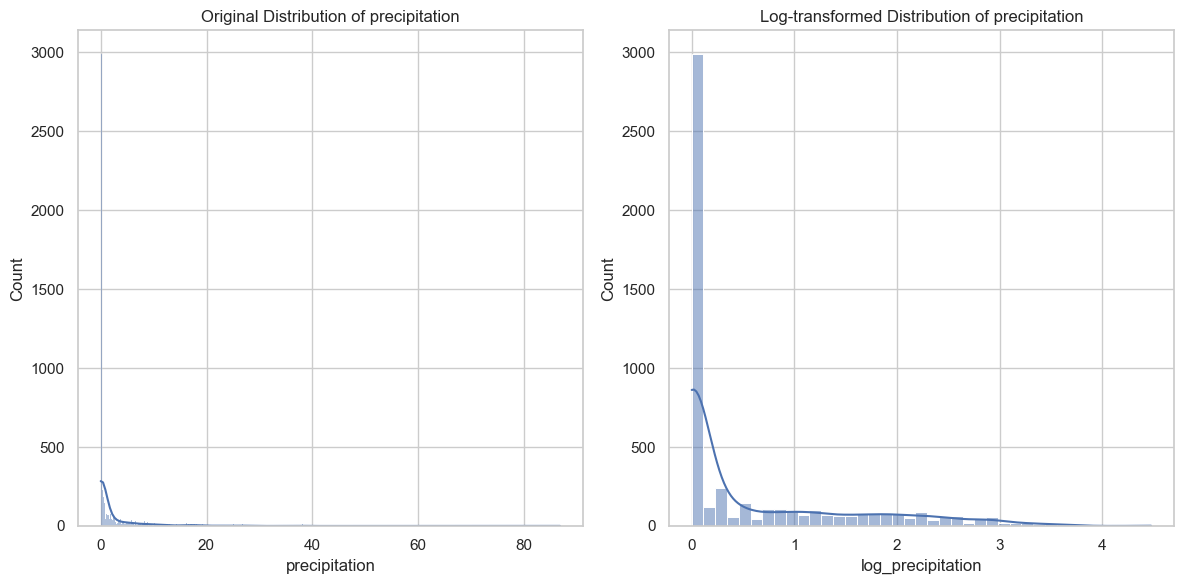

In [19]:
# Features to be transformed
features_to_transform = ['precipitation']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the original distribution
sns.histplot(crimes_df[features_to_transform[0]], kde=True, ax=axes[0])
axes[0].set_title(f'Original Distribution of {features_to_transform[0]}')

# Applying log transformation to reduce skewness
crimes_df[f'log_{features_to_transform[0]}'] = np.log1p(crimes_df[features_to_transform[0]])

# Plotting the log-transformed distribution
sns.histplot(crimes_df[f'log_{features_to_transform[0]}'], kde=True, ax=axes[1])
axes[1].set_title(f'Log-transformed Distribution of {features_to_transform[0]}')

plt.tight_layout()
plt.show()

# Dropping the original feature
crimes_df.drop(columns=features_to_transform, inplace=True)

### Dataset Creation

We generate datasets for crime occurrences in both the overall York Region as well as for each individual district.

In [20]:
# Aggregating all crimes per day across all districts
df_all_crimes_per_day = crimes_df.groupby('date').agg({'Number_of_Crimes': 'sum'}).reset_index()

# Select a representative row for each date to extract common features across all districts
representative_rows = crimes_df.groupby('date').first().reset_index()

# Drop the columns that are not common across all districts ('district' and 'Number_of_Crimes') or we don't want them anymore
representative_rows = representative_rows.drop(columns=['district', 'Number_of_Crimes'])

# Merge the common features with the df_all_crimes_per_day
df_all_crimes_per_day = pd.merge(df_all_crimes_per_day, representative_rows, on='date')

df_all_crimes_per_day.head()

date  Number_of_Crimes  year  Year_Circle_X  Year_Circle_Y  \
0 2021-01-01              50.0  2021       0.508607       0.999926   
1 2021-01-02              58.0  2021       0.517211       0.999704   
2 2021-01-03              54.0  2021       0.525810       0.999333   
3 2021-01-04              61.0  2021       0.534401       0.998815   
4 2021-01-05              72.0  2021       0.542982       0.998149   

   is_holiday  unemployment_rate  mean_temp  snow_on_ground  \
0        True                9.2       -2.5             5.0   
1       False                9.2       -1.8            10.0   
2       False                9.2       -1.6            10.0   
3       False                9.2       -2.1            11.0   
4       False                9.2       -1.5            11.0   

   icu_current_covid  log_precipitation  
0              117.0           0.993252  
1              120.0           1.987874  
2              122.0           1.360977  
3              125.0           0.000000  
4              133.0           0.000000

In [21]:
# Create a list of unique dates and districts
unique_districts = crimes_df['district'].unique()

# Create a dictionary of DataFrames, one for each district
df_crimes_per_dist = {dist: crimes_df[crimes_df['district'] == dist].drop(columns='district').reset_index(drop=True) for dist in unique_districts}

# Show the first few rows of the DataFrame for District 1 as an example after resetting the index
df_crimes_per_dist['District 1'].head()

date  Number_of_Crimes  year  Year_Circle_X  Year_Circle_Y  \
0 2021-01-01              15.0  2021       0.508607       0.999926   
1 2021-01-02               9.0  2021       0.517211       0.999704   
2 2021-01-03               3.0  2021       0.525810       0.999333   
3 2021-01-04              12.0  2021       0.534401       0.998815   
4 2021-01-05              17.0  2021       0.542982       0.998149   

   is_holiday  unemployment_rate  mean_temp  snow_on_ground  \
0        True                9.2       -2.5             5.0   
1       False                9.2       -1.8            10.0   
2       False                9.2       -1.6            10.0   
3       False                9.2       -2.1            11.0   
4       False                9.2       -1.5            11.0   

   icu_current_covid  log_precipitation  
0              117.0           0.993252  
1              120.0           1.987874  
2              122.0           1.360977  
3              125.0           0.000000  
4              133.0           0.000000

### Crimes Probability Distribution

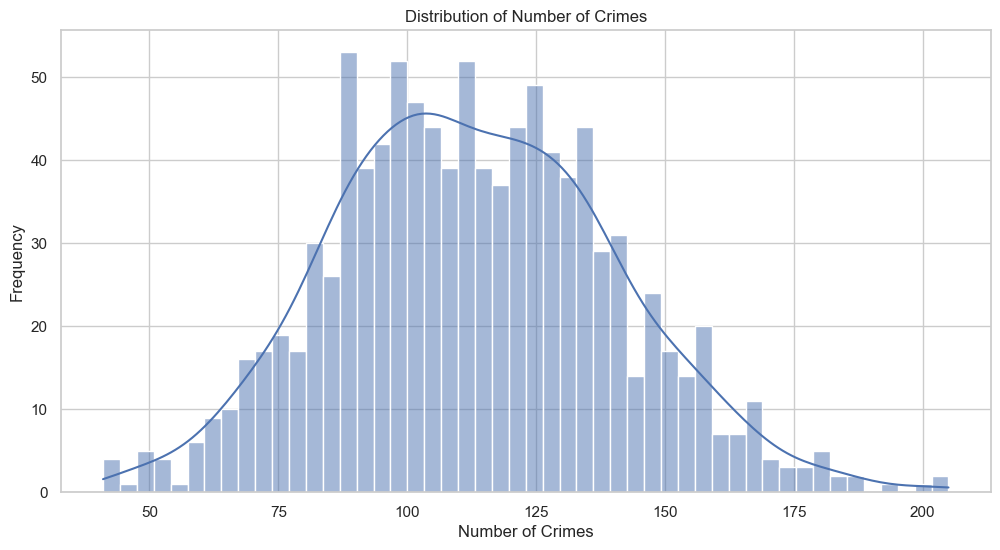

count    1052.000000
mean      109.678707
std        32.890057
min         0.000000
25%        92.000000
50%       110.000000
75%       131.000000
max       205.000000
Name: Number_of_Crimes, dtype: float64

In [22]:
plt.figure(figsize=(12, 6))
sns.histplot(df_all_crimes_per_day['Number_of_Crimes'].iloc[:-30], bins=50, kde=True)
plt.title('Distribution of Number of Crimes')
plt.xlabel('Number of Crimes')
plt.ylabel('Frequency')
plt.show()

df_all_crimes_per_day['Number_of_Crimes'].describe()

It seams like a normal distribution. Let's find out!

In [23]:
# Performing a Shapiro-Wilk test to check for normality
shapiro_test_stat, shapiro_p_value = stats.shapiro(df_all_crimes_per_day['Number_of_Crimes'].iloc[:-150])

shapiro_test_stat, shapiro_p_value

(0.9940388798713684, 0.0012061537709087133)

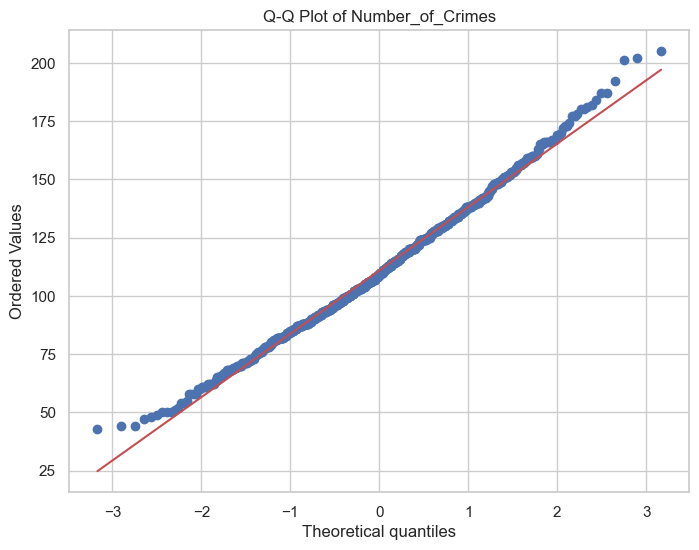

In [24]:
# Plotting the Q-Q plot
plt.figure(figsize=(8, 6))
stats.probplot(df_all_crimes_per_day['Number_of_Crimes'].iloc[:-150], plot=plt)
plt.title('Q-Q Plot of Number_of_Crimes')
plt.show()

Apparently it is not! But it is really close to a normal distribution.

### Data Visualization
Now let's visualize target and some feature to get a better feeling about them.

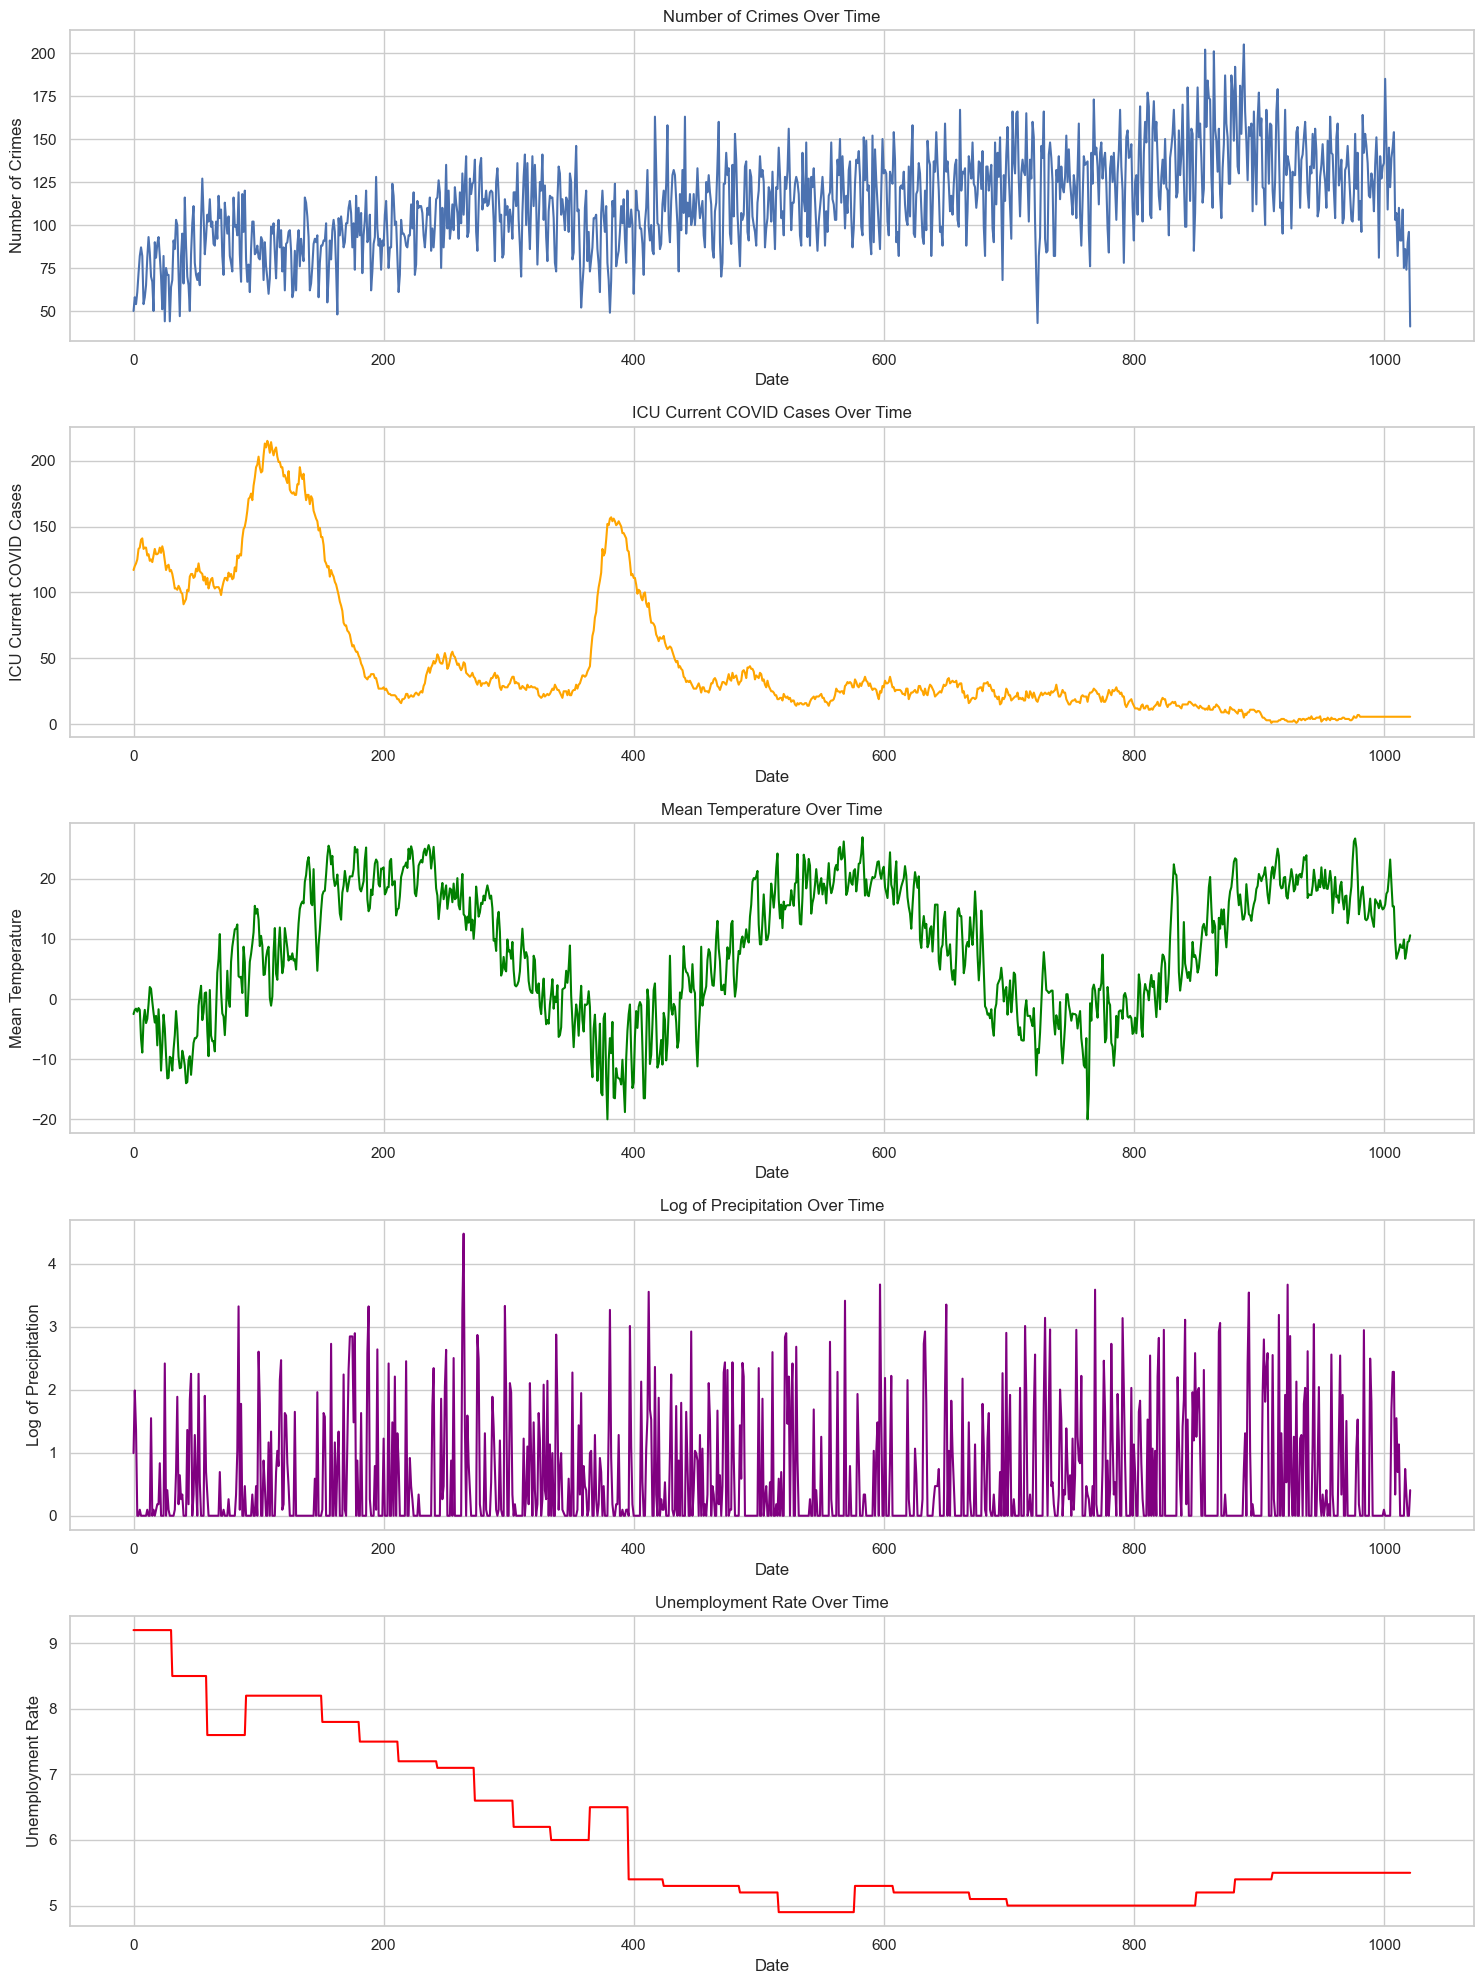

In [25]:
# Set the style for the visualizations
sns.set(style="whitegrid")

# Create subplots for selected features and Number_of_Crimes
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 20))

# Plot Number_of_Crimes
sns.lineplot(x=df_all_crimes_per_day.iloc[:-30].index, y='Number_of_Crimes', data=df_all_crimes_per_day.iloc[:-30], ax=axes[0])
axes[0].set_title('Number of Crimes Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Crimes')

# Plot ICU current covid cases
sns.lineplot(x=df_all_crimes_per_day.index, y='icu_current_covid', data=df_all_crimes_per_day, ax=axes[1], color='orange')
axes[1].set_title('ICU Current COVID Cases Over Time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('ICU Current COVID Cases')

# Plot Mean Temperature
sns.lineplot(x=df_all_crimes_per_day.index, y='mean_temp', data=df_all_crimes_per_day, ax=axes[2], color='green')
axes[2].set_title('Mean Temperature Over Time')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Mean Temperature')

# Plot Precipitation
sns.lineplot(x=df_all_crimes_per_day.index, y='log_precipitation', data=df_all_crimes_per_day, ax=axes[3], color='purple')
axes[3].set_title('Log of Precipitation Over Time')
axes[3].set_xlabel('Date')
axes[3].set_ylabel('Log of Precipitation')

# Plot Unemployment Rate
sns.lineplot(x=df_all_crimes_per_day.index, y='unemployment_rate', data=df_all_crimes_per_day, ax=axes[4], color='red')
axes[4].set_title('Unemployment Rate Over Time')
axes[4].set_xlabel('Date')
axes[4].set_ylabel('Unemployment Rate')

plt.tight_layout()
plt.show()

The target variable appears to be quite volatile, showing significant fluctuations. This is particularly interesting when compared to another inherently unstable metric like the "Number of People in ICU."

Additionally, it's worth noting a sudden decline in the dataset's last few days. This drop is likely due to a lag in data updating, rather than an actual decrease in incidents. To mitigate this issue, we will exclude the last 14 days from the training and validation processes to ensure the model's accuracy and reliability.

### Feature Standardization

In [26]:
# Initialize the MinMaxScaler
standard_scaler = MinMaxScaler()

# List of features to apply MinMaxScaler
zscore_features = ['icu_current_covid', 'mean_temp', 'log_precipitation', 'snow_on_ground', 'unemployment_rate']

# Apply MinMaxScaler to df_all_crimes_per_day
df_all_crimes_per_day[zscore_features] = standard_scaler.fit_transform(df_all_crimes_per_day[zscore_features])

# Apply MinMaxScaler to each DataFrame in df_crimes_per_district
for district, df in df_crimes_per_dist.items():
    df[zscore_features] = standard_scaler.fit_transform(df[zscore_features])
    
df_all_crimes_per_day.head()

date  Number_of_Crimes  year  Year_Circle_X  Year_Circle_Y  \
0 2021-01-01              50.0  2021       0.508607       0.999926   
1 2021-01-02              58.0  2021       0.517211       0.999704   
2 2021-01-03              54.0  2021       0.525810       0.999333   
3 2021-01-04              61.0  2021       0.534401       0.998815   
4 2021-01-05              72.0  2021       0.542982       0.998149   

   is_holiday  unemployment_rate  mean_temp  snow_on_ground  \
0        True                1.0   0.373134        0.135135   
1       False                1.0   0.388060        0.270270   
2       False                1.0   0.392324        0.270270   
3       False                1.0   0.381663        0.297297   
4       False                1.0   0.394456        0.297297   

   icu_current_covid  log_precipitation  
0           0.542056           0.221953  
1           0.556075           0.444212  
2           0.565421           0.304125  
3           0.579439           0.000000  
4           0.616822           0.000000

### Correlation Matrix

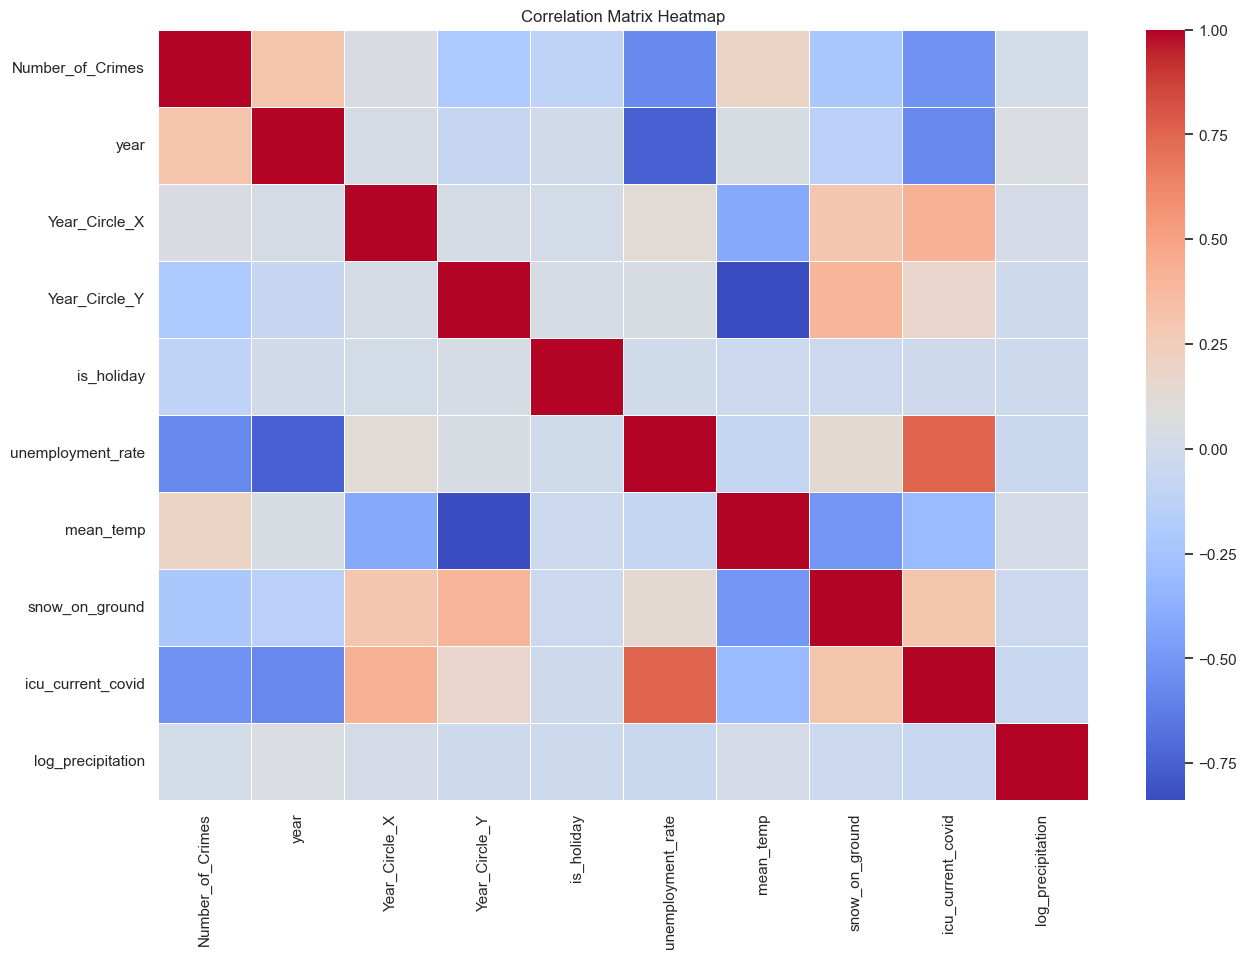

Number_of_Crimes     1.000000
year                 0.317542
mean_temp            0.195138
Year_Circle_X        0.046738
log_precipitation    0.007615
is_holiday          -0.108168
Year_Circle_Y       -0.209264
snow_on_ground      -0.213112
icu_current_covid   -0.530018
unemployment_rate   -0.564789
Name: Number_of_Crimes, dtype: float64

In [27]:
# Calculate the correlation matrix to understand the relationships between variables
correlation_matrix = df_all_crimes_per_day[df_all_crimes_per_day.drop(columns='date').columns].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Show the correlation of all features with 'Number_of_Crimes'
correlation_with_target = correlation_matrix['Number_of_Crimes'].sort_values(ascending=False)
correlation_with_target

### Weighted Moving Averages for Forecasting

1. **Function**: A helper function `weighted_moving_average()` calculates the weighted moving average for a given series and window size.

2. **Window & Weights**: A 30-day window is defined with two sets of weights. One gives higher weight to recent days (`month_weights_sharp`), while the other has equal weight for all days (`month_weights_soft`).

3. **Features**: Weighted moving averages are calculated for features like 'mean_temp' and 'unemployment_rate'.

4. **Crime Data**: Two types of weighted moving averages for the number of crimes are also calculated—one with sharp weights and one with soft weights.

5. **Change Features**: We create a new feature capturing the change in the moving average over the month.

By incorporating these weighted moving averages and change features, we enhance our model's ability to capture trends and seasonality.

In [28]:
# Helper function to calculate weighted moving average
def weighted_moving_average(series, window_size, weights):
    """
    Calculate the weighted moving average of a series.
    
    Parameters:
        series (pd.Series): The series to calculate the weighted moving average for.
        window_size (int): The size of the moving window.
        weights (list): The weights for the moving window.
    
    Returns:
        pd.Series: A series containing the weighted moving average.
    """
    return series.rolling(window=window_size).apply(lambda x: np.dot(x, weights) / np.sum(weights), raw=True)

# Define window sizes and weights for one-month forecasts
month_window_size = 30

# Weights for one-month forecast (higher weight to recent days)
month_weights_sharp = np.linspace(1, month_window_size, month_window_size)
month_weights_soft = np.linspace(1, 1, month_window_size)

# Columns for which we will calculate weighted moving averages.
# NOT ICU and snow_on_ground because they are cumulative feature themselves.
avg_columns = ['mean_temp', 'log_precipitation', 'unemployment_rate']
change_columns = ['Number_of_Crimes', 'mean_temp', 'log_precipitation', 'snow_on_ground', 'icu_current_covid']


# Create weighted moving averages for one-month forecast
# The initial 29 days will have NaN values
for col in avg_columns:
    df_all_crimes_per_day[f"{col}_month_wma"] = weighted_moving_average(df_all_crimes_per_day[col], month_window_size, month_weights_sharp)
df_all_crimes_per_day["Number_of_Crimes_month_wma_sharp"] = weighted_moving_average(df_all_crimes_per_day['Number_of_Crimes'], month_window_size, month_weights_sharp)
df_all_crimes_per_day["Number_of_Crimes_month_wma_soft"] = weighted_moving_average(df_all_crimes_per_day['Number_of_Crimes'], month_window_size, month_weights_soft)
for district, df in df_crimes_per_dist.items():
    for col in avg_columns:
        df[f"{col}_month_wma"] = weighted_moving_average(df[col], month_window_size, month_weights_sharp)
    df["Number_of_Crimes_month_wma_sharp"] = weighted_moving_average(df['Number_of_Crimes'], month_window_size, month_weights_sharp)
    df["Number_of_Crimes_month_wma_soft"] = weighted_moving_average(df['Number_of_Crimes'], month_window_size, month_weights_soft)


# Create moving average change features for one-month forecast
# The initial 29 days will have NaN values
for col in change_columns:
    df_all_crimes_per_day[f"{col}_month_wma_change"] = df_all_crimes_per_day[col].rolling(window=30).apply(lambda x: x[-15:].mean() - x[:15].mean(), raw=True)
for district, df in df_crimes_per_dist.items():
    for col in change_columns:
        df[f"{col}_month_wma_change"] = df[col].rolling(window=30).apply(lambda x: x[-15:].mean() - x[:15].mean(), raw=True)
    
df_all_crimes_per_day.head()

date  Number_of_Crimes  year  Year_Circle_X  Year_Circle_Y  \
0 2021-01-01              50.0  2021       0.508607       0.999926   
1 2021-01-02              58.0  2021       0.517211       0.999704   
2 2021-01-03              54.0  2021       0.525810       0.999333   
3 2021-01-04              61.0  2021       0.534401       0.998815   
4 2021-01-05              72.0  2021       0.542982       0.998149   

   is_holiday  unemployment_rate  mean_temp  snow_on_ground  \
0        True                1.0   0.373134        0.135135   
1       False                1.0   0.388060        0.270270   
2       False                1.0   0.392324        0.270270   
3       False                1.0   0.381663        0.297297   
4       False                1.0   0.394456        0.297297   

   icu_current_covid  ...  mean_temp_month_wma  log_precipitation_month_wma  \
0           0.542056  ...                  NaN                          NaN   
1           0.556075  ...                  NaN                          NaN   
2           0.565421  ...                  NaN                          NaN   
3           0.579439  ...                  NaN                          NaN   
4           0.616822  ...                  NaN                          NaN   

   unemployment_rate_month_wma  Number_of_Crimes_month_wma_sharp  \
0                          NaN                               NaN   
1                          NaN                               NaN   
2                          NaN                               NaN   
3                          NaN                               NaN   
4                          NaN                               NaN   

   Number_of_Crimes_month_wma_soft  Number_of_Crimes_month_wma_change  \
0                              NaN                                NaN   
1                              NaN                                NaN   
2                              NaN                                NaN   
3                              NaN                                NaN   
4                              NaN                                NaN   

   mean_temp_month_wma_change  log_precipitation_month_wma_change  \
0                         NaN                                 NaN   
1                         NaN                                 NaN   
2                         NaN                                 NaN   
3                         NaN                                 NaN   
4                         NaN                                 NaN   

   snow_on_ground_month_wma_change  icu_current_covid_month_wma_change  
0                              NaN                                 NaN  
1                              NaN                                 NaN  
2                              NaN                                 NaN  
3                              NaN                                 NaN  
4                              NaN                                 NaN  

[5 rows x 21 columns]

In [29]:
df_all_crimes_per_day.columns

Index(['date', 'Number_of_Crimes', 'year', 'Year_Circle_X', 'Year_Circle_Y',
       'is_holiday', 'unemployment_rate', 'mean_temp', 'snow_on_ground',
       'icu_current_covid', 'log_precipitation', 'mean_temp_month_wma',
       'log_precipitation_month_wma', 'unemployment_rate_month_wma',
       'Number_of_Crimes_month_wma_sharp', 'Number_of_Crimes_month_wma_soft',
       'Number_of_Crimes_month_wma_change', 'mean_temp_month_wma_change',
       'log_precipitation_month_wma_change', 'snow_on_ground_month_wma_change',
       'icu_current_covid_month_wma_change'],
      dtype='object')

### Data Transformation for Monthly Forecasting

1. **Holiday Average**: Calculate the rolling 30-day mean of holidays for the next month and store it in 'Avg_Holidays_Next_Month'. Drop the original 'is_holiday' column.
  
2. **Time Shift**: Shift crime numbers and time-related features by specified days to align them for future prediction. This includes shifting the 'Number_of_Crimes' by -30 days and time-related features by -15 days.

3. **Target Variable**: Calculate the 30-day moving average of the shifted crime numbers and store it in 'Target_Avg_Crimes_Next_Month'.

In [30]:
df_all_crimes_per_day['Avg_Holidays_Next_Month'] = df_all_crimes_per_day['is_holiday'].rolling(window=30).mean().shift(-30)
df_all_crimes_per_day.drop(columns='is_holiday', inplace=True)

for district, df in df_crimes_per_dist.items():
    df['Avg_Holidays_Next_Month'] = df['is_holiday'].rolling(window=30).mean().shift(-30)
    df.drop(columns='is_holiday', inplace=True)

# List of columns to shift for future prediction
monthly_shift_columns = ['year', 'Year_Circle_X', 'Year_Circle_Y']

# For One-Month Forecast
# 1. Shift the labels back by 30 days and time-related features by 15 days (middle of the next month)
df_all_crimes_per_day['Shifted_Number_of_Crimes_Month'] = df_all_crimes_per_day['Number_of_Crimes'].shift(-30)
for col in monthly_shift_columns:
    new_col_name = f'Shifted_{col}_Month'
    df_all_crimes_per_day[new_col_name] = df_all_crimes_per_day[col].shift(-15)
    
for district, df in df_crimes_per_dist.items():
    df['Shifted_Number_of_Crimes_Month'] = df['Number_of_Crimes'].shift(-30)
    for col in monthly_shift_columns:
        new_col_name = f'Shifted_{col}_Month'
        df[new_col_name] = df[col].shift(-15)

# 2. Calculate the 30-day moving average for the shifted labels
df_all_crimes_per_day['Target_Avg_Crimes_Next_Month'] = df_all_crimes_per_day['Shifted_Number_of_Crimes_Month'].rolling(window=30).mean()

for district, df in df_crimes_per_dist.items():
    df['Target_Avg_Crimes_Next_Month'] = df['Shifted_Number_of_Crimes_Month'].rolling(window=30).mean()


# 3. Select relevant columns for monthly forecasts
month_columns = ['date', 'icu_current_covid', 'snow_on_ground'] + \
                [col for col in df_all_crimes_per_day.columns if "month" in col.lower() and \
                 col not in ['Shifted_Number_of_Crimes_Month', 'Month_Circle_X', 'Month_Circle_Y',
                             'Shifted_Month_Circle_X_Week', 'Shifted_Month_Circle_Y_Week', 'unemployment_rate_month_wma']]

### Data Splitting for Model Training and Prediction

1. **Labeled Data**: Create `df_month_labeled` by excluding the first 29 and last 74 days from the original data. Do the same for each district's data.

2. **Future Data**: Create `df_month_future` by selecting the last 74 days minus the last 30 days from the original data. Again, do the same for each district.

3. **Train-Test Split**: Partition the labeled data into training and test sets, keeping 80% for training and 20% for testing. This is done both for the entire region and for individual districts.

4. **Feature-Label Separation**: Isolate the features (`X_train` and `X_test`) from the target label (`y_train` and `y_test`) for the training and test sets.

In [31]:
# Create DataFrame for training and DataFrame for future month predictions
df_month_labeled = df_all_crimes_per_day[month_columns].iloc[29:-(30+30+14)]
df_month_future = df_all_crimes_per_day[month_columns].iloc[-(30+30+14):-30]

df_month_labeled_per_dist, df_month_future_per_dist = {}, {}
for district, df in df_crimes_per_dist.items():
    df_month_labeled_per_dist[district] = df[month_columns].iloc[29:-(30+30+14)]
    df_month_future_per_dist[district] = df[month_columns].iloc[-(30+30+14):-30]

In [32]:
train_data_month, test_data_month = train_test_split(df_month_labeled, test_size=0.2, shuffle=False)

train_data_month_per_dist, test_data_month_per_dist = {}, {}
for district, df in df_month_labeled_per_dist.items():
    #print(district, df.tail())
    train_data_month_per_dist[district], test_data_month_per_dist[district] = train_test_split(df, test_size=0.2, shuffle=False)
    #print(district, test_data_month_per_dist[district].tail())

In [33]:
target_column = 'Target_Avg_Crimes_Next_Month'
X_train = train_data_month.drop(columns=[target_column, 'date'])
y_train = train_data_month[target_column]
X_test = test_data_month.drop(columns=[target_column, 'date'])
y_test = test_data_month[target_column]

X_train_per_dist, y_train_per_dist, X_test_per_dist, y_test_per_dist = {}, {}, {}, {}
for district, df in train_data_month_per_dist.items():
    X_train_per_dist[district] = df.drop(columns=[target_column, 'date'])
    y_train_per_dist[district] = df[target_column]
for district, df in test_data_month_per_dist.items():
    X_test_per_dist[district] = df.drop(columns=[target_column, 'date'])
    y_test_per_dist[district] = df[target_column]

In [34]:
X_forcast = df_month_future.drop(columns=[target_column, 'date'])

X_forcast_per_dist = {}
for district, df in df_month_future_per_dist.items():
    X_forcast_per_dist[district] = df.drop(columns=[target_column, 'date'])

### Visualization of Target Variable for Training and Test Data

The plot visualizes the target variable 'Target_Avg_Crimes_Next_Month' for both the training and test datasets.

- **Blue Line**: Represents the training data, capturing historical trends and patterns.
  
- **Red Line**: Depicts the test data, which will be used to validate the model's predictions.

The x-axis represents the index, while the y-axis shows the average number of crimes expected in the next month. This visualization helps in understanding the distribution and trends in the target variable, aiding in model evaluation.

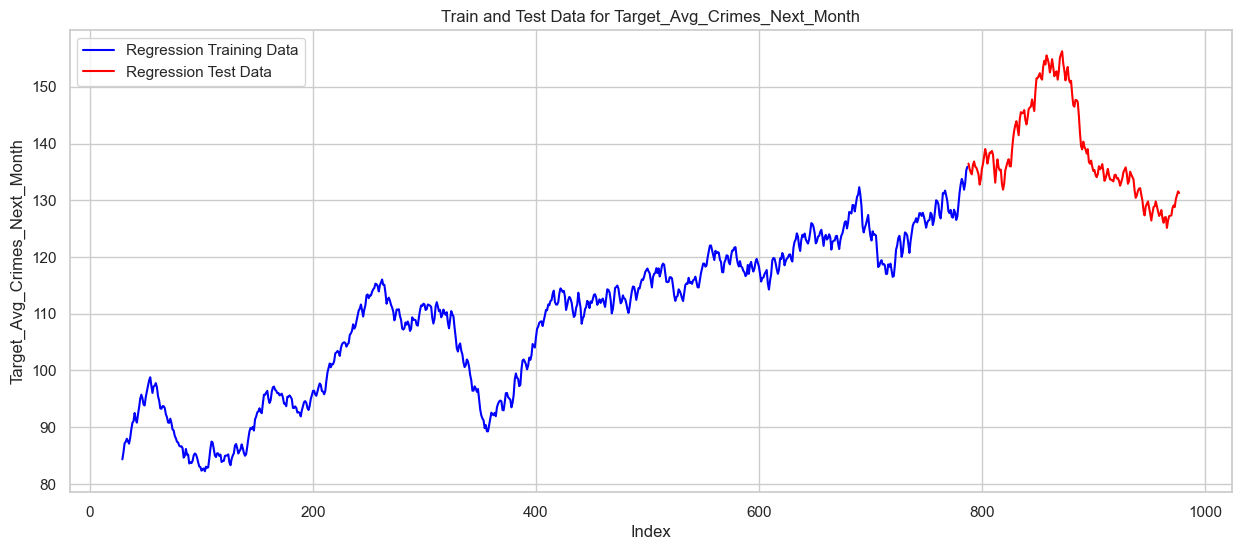

In [35]:
# Plotting the target variable 'Target_Avg_Crimes_Next_Month' in both training and test sets
plt.figure(figsize=(15, 6))

plt.plot(train_data_month.index, train_data_month['Target_Avg_Crimes_Next_Month'], label='Regression Training Data', color='blue')
plt.plot(test_data_month.index, test_data_month['Target_Avg_Crimes_Next_Month'], label='Regression Test Data', color='red')

plt.xlabel('Index')
plt.ylabel('Target_Avg_Crimes_Next_Month')
plt.title('Train and Test Data for Target_Avg_Crimes_Next_Month')
plt.legend()
plt.show()

### Utility Functions

1. **`train_model` Function**: 
    - Trains a given machine learning model on the training set.
    - Computes Mean Squared Error (MSE) on the test set.
    - Returns MSE, predictions on training and test sets.

2. **`plot_train_val_pred` Function**: 
    - Plots the actual and predicted values for both training and validation sets.
    - Takes in actual and predicted values, the model name, and the feature selection method used.
    - Displays a graph comparing actual vs. predicted values.

3. **`train_and_plot_model` Function**: 
    - Combines the above two functions.
    - Optionally performs feature selection before training the model, using either RFE (Recursive Feature Elimination) or Feature Importance.
    - Returns MSE and optionally plots the comparison graph.

In [36]:
def train_model(X_train, y_train, X_test, y_test, model=LinearRegression()):
    """
    Train a model and calculate Mean Squared Error (MSE).

    Parameters:
    - X_train, X_test, y_train, y_test: Training and validation sets
    - model: Machine learning model to train
    
    Returns:
    - mse: Mean Squared Error on the test set
    - y_train_preds: Predictions on the training set
    - y_test_pred: Predictions on the test set
    """
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    y_train_preds = model.predict(X_train)
    mse = mean_squared_error(y_test, y_test_pred)
    return mse, y_train_preds, y_test_pred

In [37]:
def plot_train_val_pred(y_train, y_train_preds, y_test, y_test_pred, model_name, target_column='Target_Avg_Crimes_Next_Month', feature_selector='None'):
    """
    Plot the target variable and predicted values in both training and test sets.

    Parameters:
    - y_train, y_train_preds, y_test, y_test_pred: Actual and predicted values for training and validation sets
    - target_column: The name of the target column
    - model_name: The name of the machine learning model used for prediction
    - feature_selector: The feature selection method used
    
    Returns: None
    """
    plt.figure(figsize=(15, 6))
    plt.plot(y_train.index, y_train, label='Training Data', color='blue')
    plt.plot(y_train.index, y_train_preds, label='Train Predicted', color='green', linestyle='--')
    plt.plot(y_test.index, y_test, label='Validation Data', color='red')
    plt.plot(y_test.index, y_test_pred, label='Validation Predicted', color='green', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel(target_column)
    plt.title(f'{target_column} - Actual vs Predicted ({model_name} with {feature_selector})')
    plt.legend()
    plt.show()

In [38]:
def train_and_plot_model(X_train, y_train, X_test, y_test, model, n_features = None, target_column = 'Target_Avg_Crimes_Next_Month', feature_selector=None, plot=True):
    """
    Train a model using selected number of features, calculate MSE, and plot predictions.

    Parameters:
    - X_train, X_test, y_train, y_test: Training and validation sets
    - model: Machine learning model to train
    - n_features: Number of features to keep
    - feature_selector: Feature selection method ('RFE' or 'Feature Importance')
    - target_column: Name of the target column
    
    Returns:
    - mse: Mean Squared Error on the validation set
    - y_train_preds: Predictions on the training set
    - y_test_pred: Predictions on the test set
    """
    if feature_selector == 'RFE':
        selector = RFE(estimator=model, n_features_to_select=n_features).fit(X_train, y_train)
        X_train_selected = selector.transform(X_train)
        X_test_selected = selector.transform(X_test)
    elif feature_selector == 'Feature Importance':
        selector = RandomForestRegressor(random_state=42).fit(X_train, y_train)
        importances = selector.feature_importances_
        indices = np.argsort(importances)[::-1][:n_features]
        X_train_selected = X_train.iloc[:, indices]
        X_test_selected = X_test.iloc[:, indices]
    elif feature_selector == None:
        X_train_selected = X_train
        X_test_selected = X_test
    else:
        raise ValueError("Invalid feature_selector. Choose 'RFE' or 'Feature Importance'.")
    
    mse, y_train_preds, y_test_pred = train_model(X_train_selected, y_train, X_test_selected, y_test, model)
    if plot:
        plot_train_val_pred(y_train, y_train_preds, y_test, y_test_pred, target_column, model.__class__.__name__, feature_selector)
    
    return mse, y_train_preds, y_test_pred 

### Model Training and Evaluation Summary

#### Fundamental Models with Feature Selection

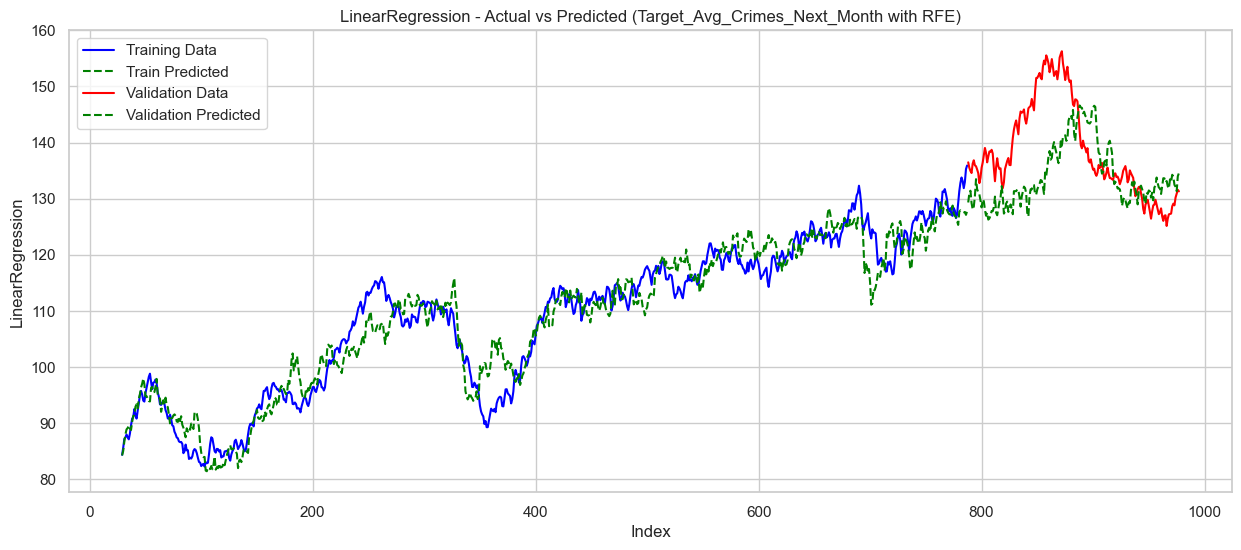

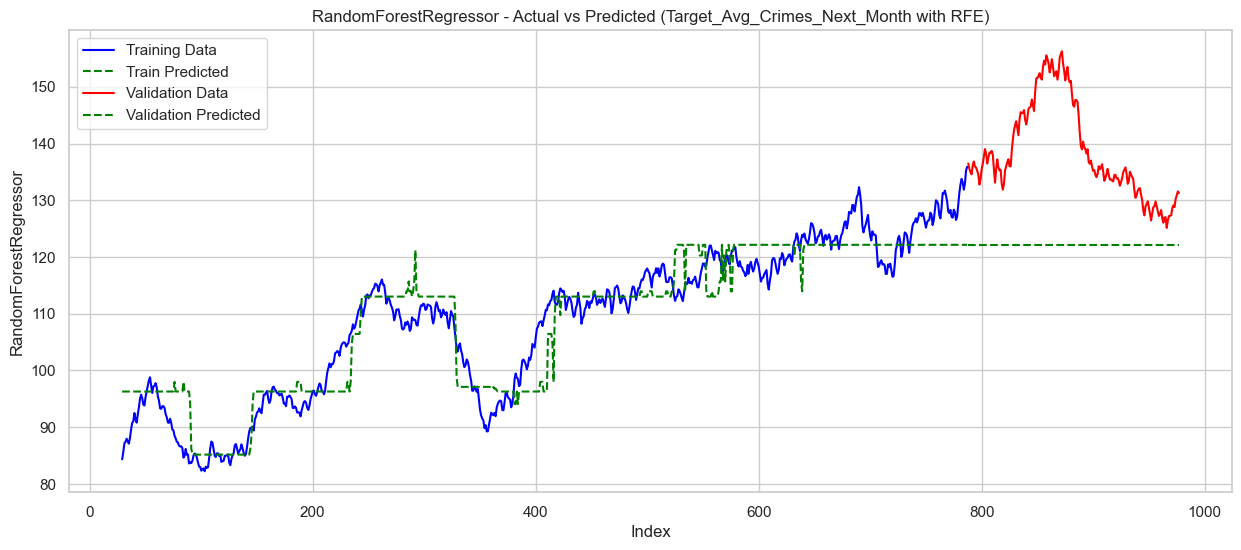

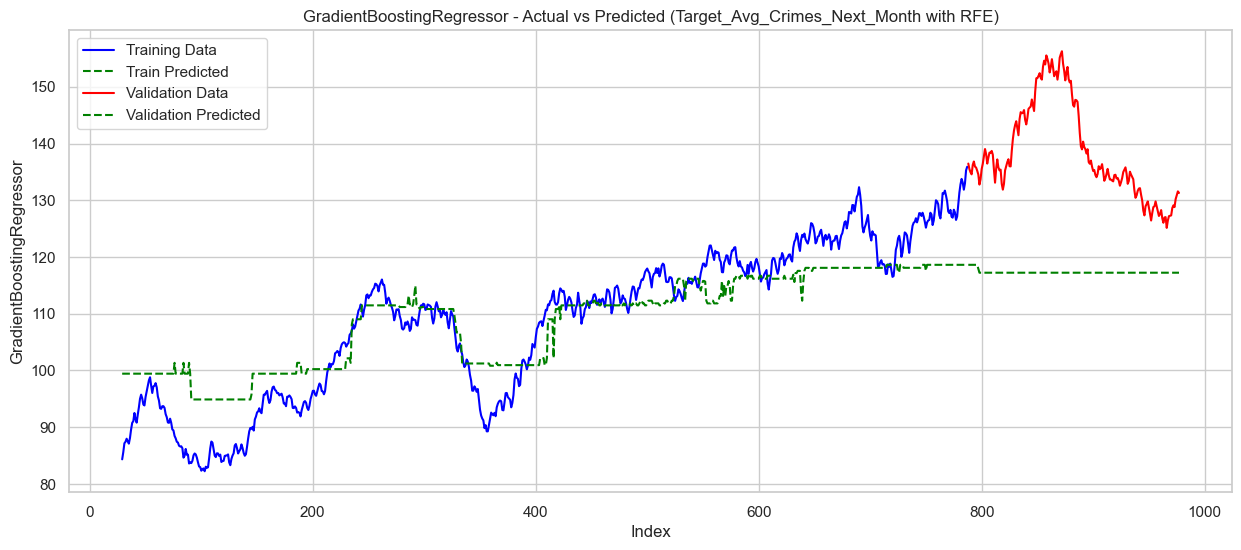

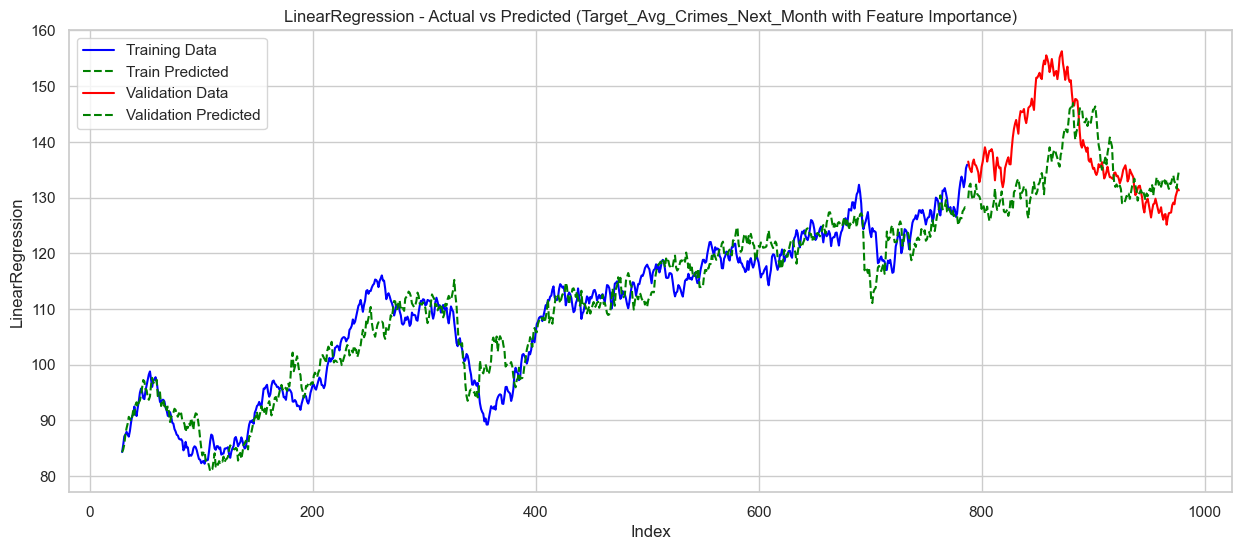

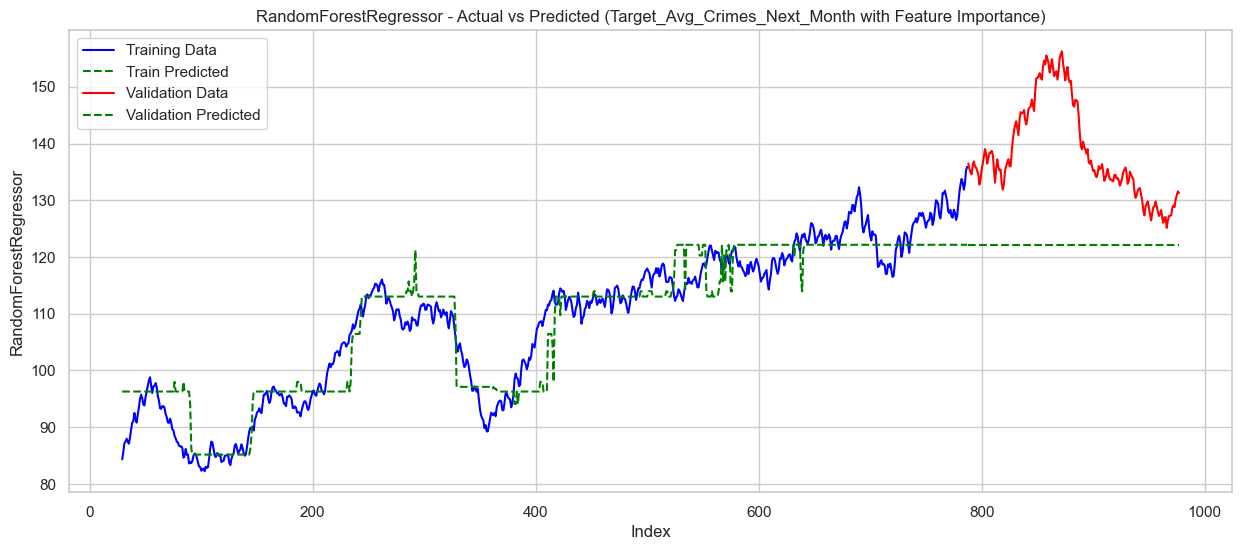

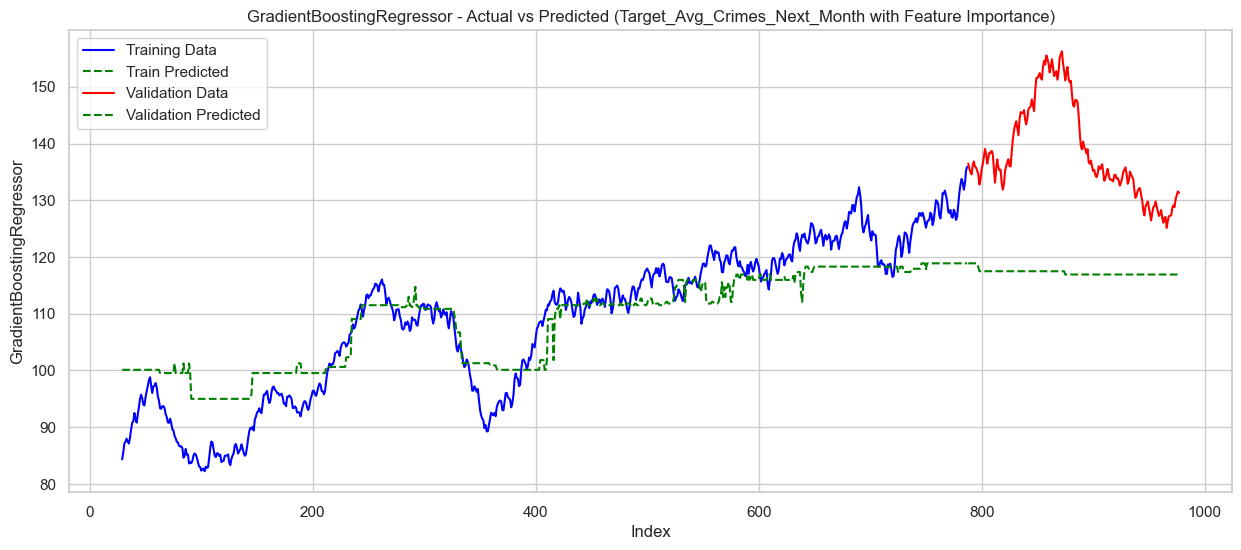

{'RFE with Linear Regression (features: 14)': 91.01486143694599,
 'RFE with Random Forest (features: 5)': 338.73027673739426,
 'RFE with Gradient Boosting (features: 5)': 521.7295000733452,
 'Feature Importance with Linear Regression (features: 14)': 91.50190052841502,
 'Feature Importance with Random Forest (features: 5)': 338.7302767373934,
 'Feature Importance with Gradient Boosting (features: 5)': 521.5853498910168}

In [39]:
# Initialize models for training
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=10, max_depth=3, min_samples_split=3, max_leaf_nodes=5, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=10, max_depth=3, min_samples_split=3, max_leaf_nodes=5, random_state=42)
    
}

# Initialize feature selectors
feature_selectors = ['RFE', 'Feature Importance']

# Store MSE for each combination
mse_results = {}

# Number of features to keep for each model
features_to_keep = {
    'Linear Regression': 14,
    'Random Forest': 5,
    'Gradient Boosting': 5
}

# Perform feature selection and model training
for fs in feature_selectors:
    for model_name, model in models.items():
        n_features = features_to_keep[model_name]
        mse, y_train_preds, y_test_pred = train_and_plot_model(
            X_train, y_train, X_test, y_test, model, n_features,
            target_column='Target_Avg_Crimes_Next_Month',
            feature_selector=fs
        )
        mse_results[f"{fs} with {model_name} (features: {n_features})"] = mse

mse_results

#### Ridge and Lasso

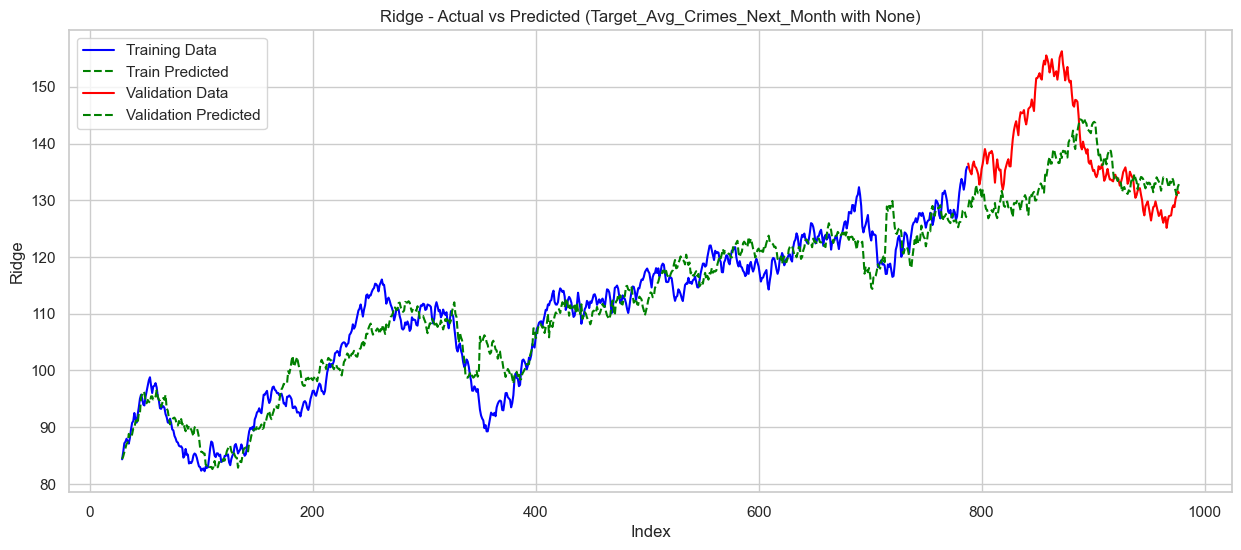

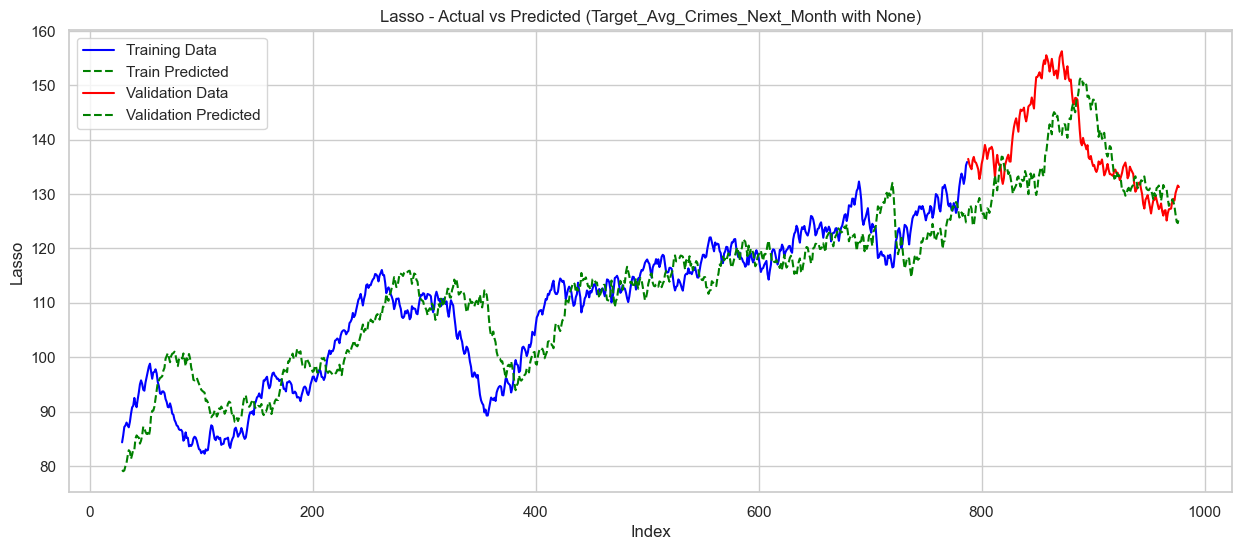

{'Ridge': 96.2338807248039, 'Lasso': 78.81594860966811}

In [40]:
# Initialize models for training
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),  
}


# Store MSE for each combination
mse_results = {}

# Perform model training
for model_name, model in models.items():
    mse, y_train_preds, y_test_pred = train_and_plot_model(
        X_train, y_train, X_test, y_test, model

    )
    mse_results[f"{model_name}"] = mse

mse_results

#### Ridge and Lasso Tuning

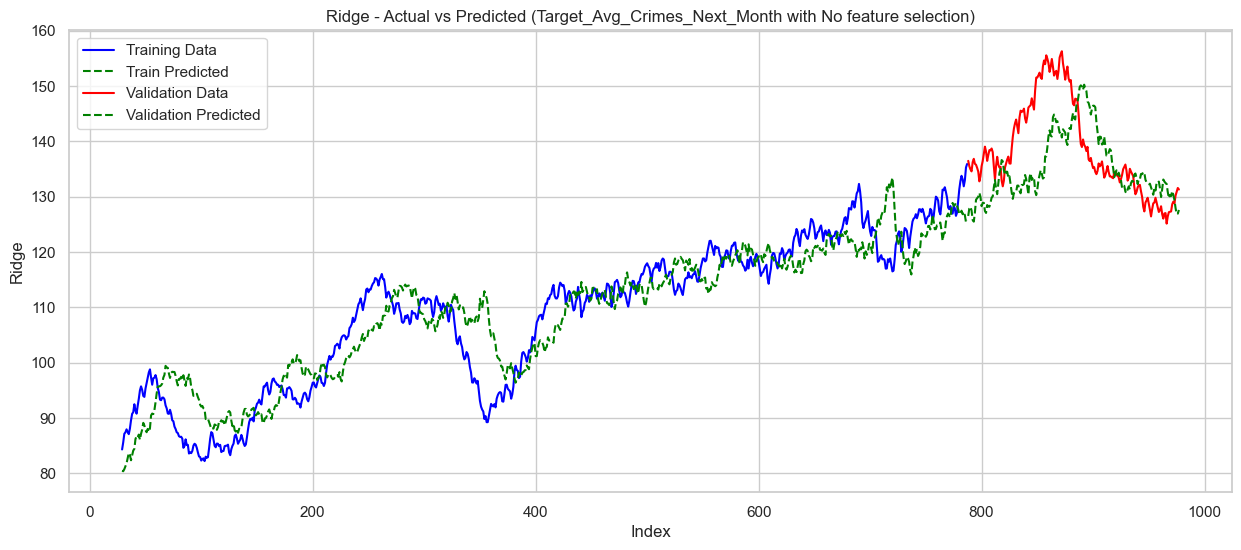

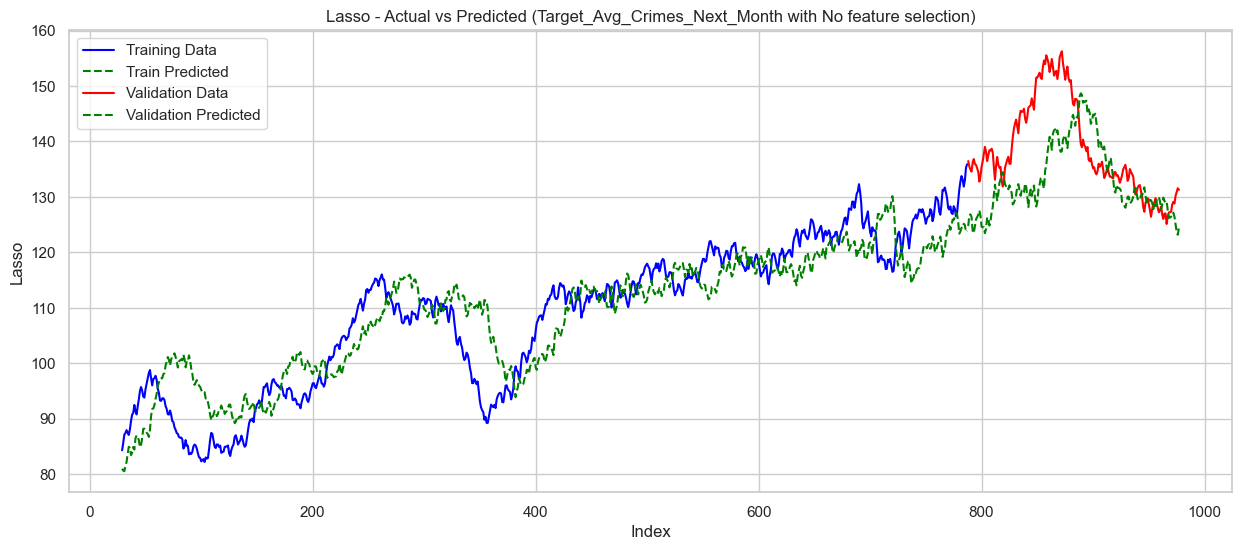

(145.63484775012444, 11.513953993264481, 76.88148241213823, 92.8609843588989)

In [41]:
# Initialize models for Ridge and Lasso
ridge_model = Ridge()
lasso_model = Lasso()

# Time Series Split
tscv = TimeSeriesSplit(n_splits=5)

# Define parameter grid for Ridge and Lasso
param_grid_ridge = {'alpha': np.logspace(-5, 4, 50)}
param_grid_lasso = {'alpha': np.logspace(-5, 4, 50)}

# GridSearchCV for Ridge with TimeSeriesSplit
grid_ridge = GridSearchCV(ridge_model, param_grid_ridge, cv=tscv, scoring='neg_mean_squared_error')
grid_ridge.fit(X_train, y_train)

# GridSearchCV for Lasso with TimeSeriesSplit
grid_lasso = GridSearchCV(lasso_model, param_grid_lasso, cv=tscv, scoring='neg_mean_squared_error')
grid_lasso.fit(X_train, y_train)

# Best parameters for Ridge and Lasso
best_alpha_ridge = grid_ridge.best_params_['alpha']
best_alpha_lasso = grid_lasso.best_params_['alpha']

# Train and evaluate Ridge with best alpha
ridge_model_best = Ridge(alpha=best_alpha_ridge)
mse_ridge, y_train_preds_ridge, y_test_pred_ridge = train_model(X_train, y_train, X_test, y_test, ridge_model_best)
# Assuming that plot_train_val_pred and train_model are your custom functions
plot_train_val_pred(y_train, y_train_preds_ridge, y_test, y_test_pred_ridge, target_column, 'Ridge', 'No feature selection')

# Train and evaluate Lasso with best alpha
lasso_model_best = Lasso(alpha=best_alpha_lasso)
mse_lasso, y_train_preds_lasso, y_test_pred_lasso = train_model(X_train, y_train, X_test, y_test, lasso_model_best)
plot_train_val_pred(y_train, y_train_preds_lasso, y_test, y_test_pred_lasso, target_column, 'Lasso', 'No feature selection')

best_alpha_ridge, best_alpha_lasso, mse_ridge, mse_lasso

#### GLMs

In [42]:
# A modification in on a solver class so it does not print a specific warning
class MyGPR(GaussianProcessRegressor):
    def __init__(self, *args, max_iter=2e05, gtol=1e-06, **kwargs):
        super().__init__(*args, **kwargs)
        self._max_iter = max_iter
        self._gtol = gtol

    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = scipy.optimize.minimize(obj_func, initial_theta, method="L-BFGS-B", jac=True, bounds=bounds, options={'maxiter':self._max_iter, 'gtol': self._gtol})
            _check_optimize_result("lbfgs", opt_res)
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = self.optimizer(obj_func, initial_theta, bounds=bounds)
        else:
            raise ValueError("Unknown optimizer %s." % self.optimizer)
        return theta_opt, func_min

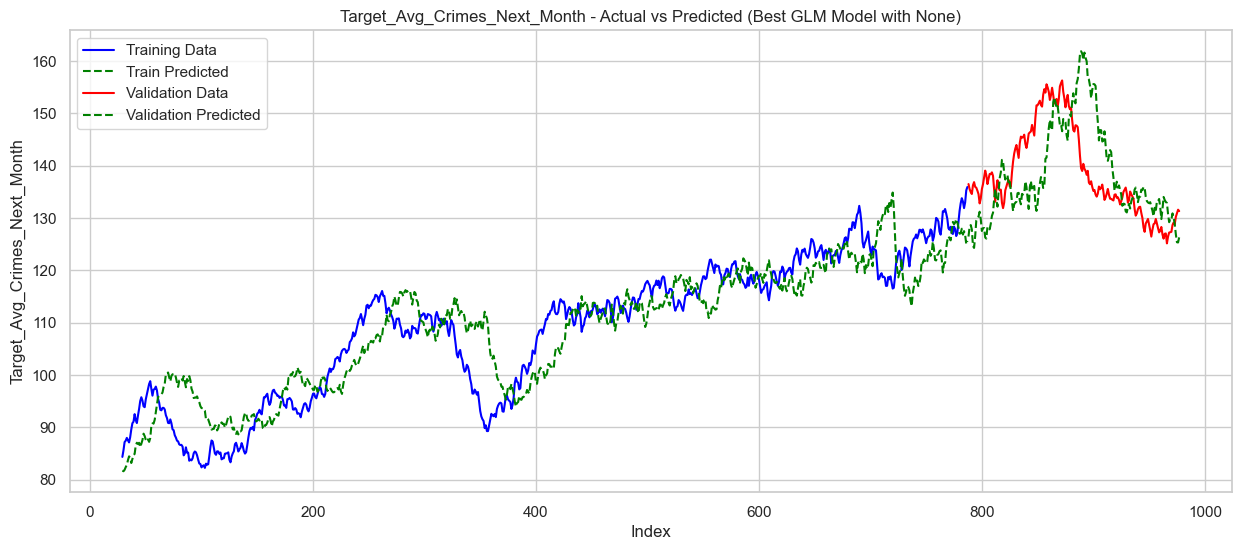

({'alpha': 1, 'max_iter': 80, 'power': 2}, 104.93703076918507)

In [43]:
glm_model = TweedieRegressor()

# Define a more comprehensive parameter grid for fine-tuning, considering valid power values and varying max_iter
param_grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 20],  # regularization strength
    'power': [1, 2, 3],  # valid distribution families (0=Normal, 1=Poisson, 2=Gamma)
    'max_iter': [50, 80, 100, 200, 300, 500, 1000, 2000]  # number of iterations
}

# Time Series Split
tscv = TimeSeriesSplit(n_splits=5)

# Initialize Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(glm_model, param_grid, cv=tscv, scoring='neg_mean_squared_error')

# Perform Grid Search on the original (unnormalized) training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the corresponding mean MSE
best_params = grid_search.best_params_
best_mse = -grid_search.best_score_
best_glm_model = grid_search.best_estimator_

# Train the model on the training set
best_glm_model.fit(X_train, y_train)

# Predict on training and validation sets
y_train_pred_best = best_glm_model.predict(X_train)
y_test_pred_best = best_glm_model.predict(X_test)

# Plot the predictions with best parameters
plot_train_val_pred(y_train, y_train_pred_best, y_test, y_test_pred_best, model_name='Best GLM Model')

best_params, best_mse

Due to the nature of cross-validation on time series, the fine-tuned parameters from cross-validation may not be exact. Alternative parameter values might yield better results.

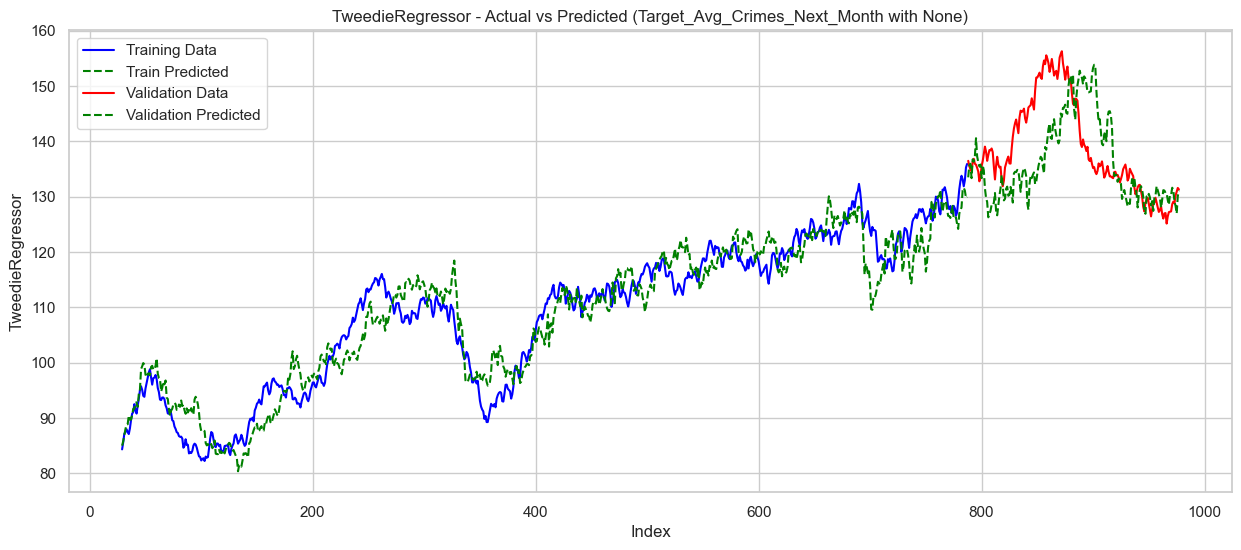

74.99228314819055


In [44]:
glm_poisson_model = TweedieRegressor(power=1, alpha=0.01, max_iter=1000)  # Poisson distribution

mse, y_train_preds, y_test_pred = train_and_plot_model(X_train, y_train, X_test, y_test, glm_poisson_model)

print(mse)

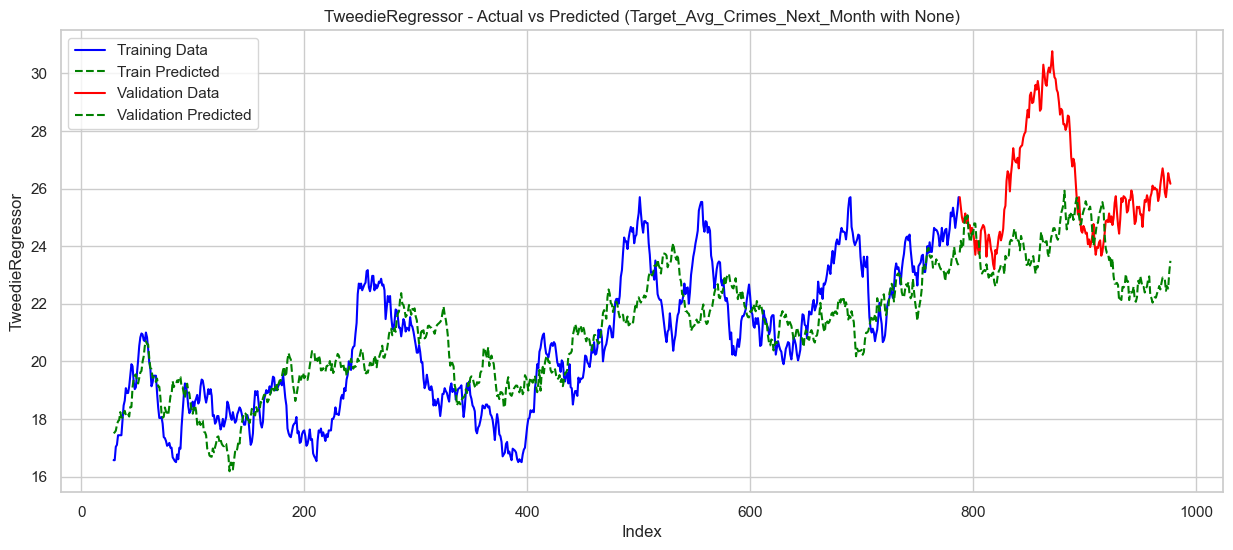

District 1 :  9.553883631319351


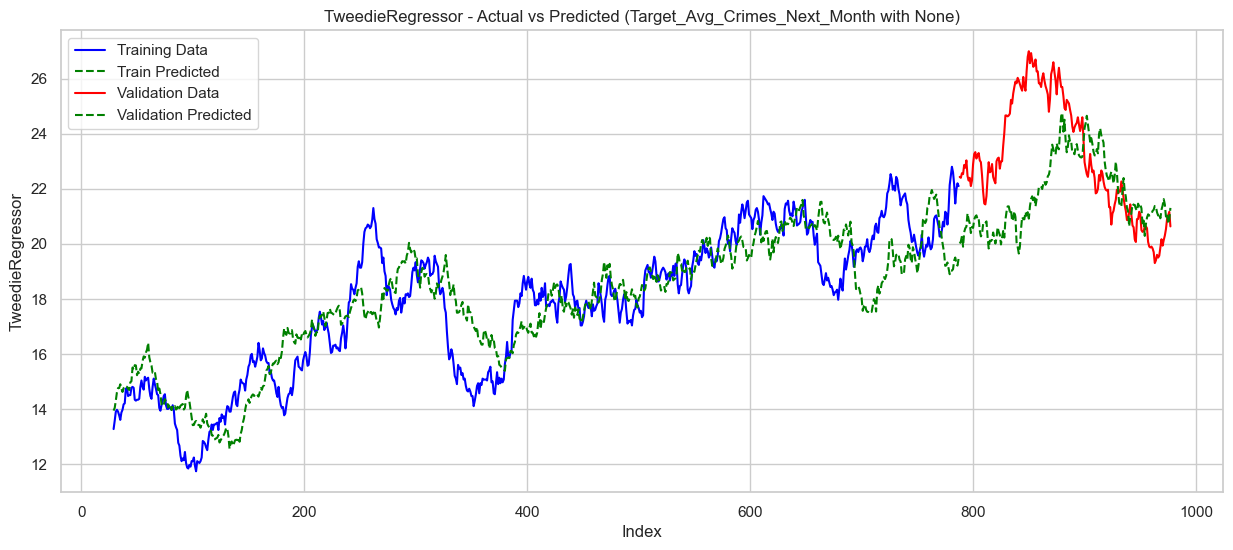

District 2 :  6.587779304392104


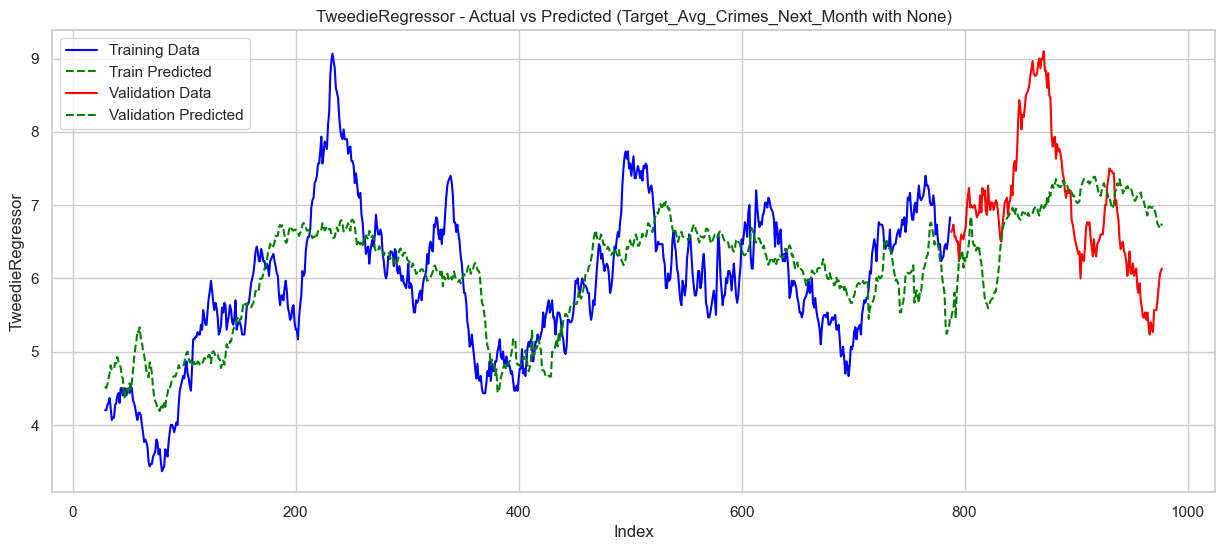

District 3 :  1.0986550437329614


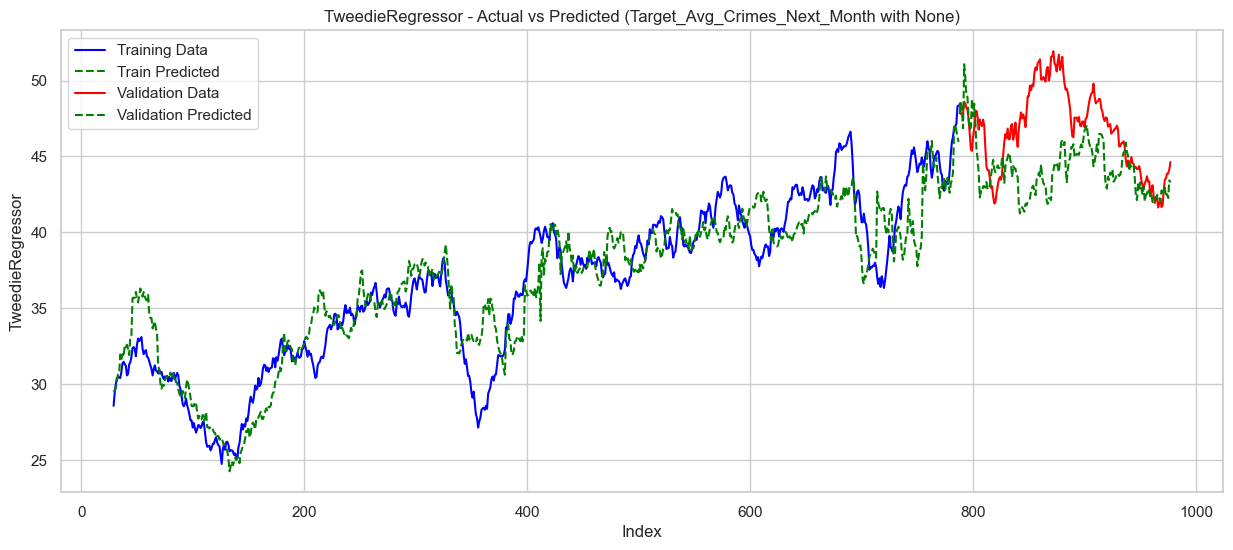

District 4 :  14.417151317756375


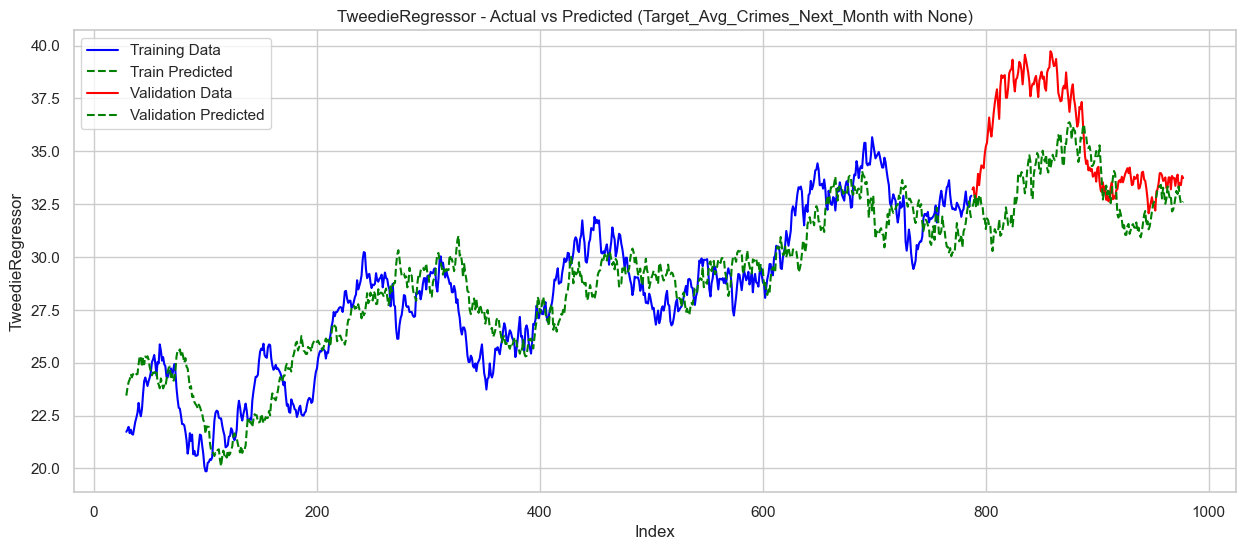

District 5 :  11.083028929029474


In [45]:
for district in df_crimes_per_dist.keys():
    glm_poisson_model = TweedieRegressor(power=1, alpha=0.01, max_iter=1000)
    mse, y_train_preds, y_test_pred = train_and_plot_model(X_train_per_dist[district],
                                                           y_train_per_dist[district],
                                                           X_test_per_dist[district],
                                                           y_test_per_dist[district],
                                                           glm_poisson_model
                                                          )
    print(district,': ', mse)

We're predicting a rate (i.e., rate of crimes), which inherently suits the Poisson Regression model. Thus, it's not surprising that this approach yields better results.

#### The most important Features in Poisson Regression

In [46]:
# Add a constant column to the predictor variables
X_train_with_const = sm.add_constant(X_train)

# Fit the Poisson regression model
poisson_model = sm.GLM(y_train, X_train_with_const, family=sm.families.Poisson()).fit()

poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                       
========================================================================================
Dep. Variable:     Target_Avg_Crimes_Next_Month   No. Observations:                  759
Model:                                      GLM   Df Residuals:                      743
Model Family:                           Poisson   Df Model:                           15
Link Function:                              Log   Scale:                          1.0000
Method:                                    IRLS   Log-Likelihood:                -2529.3
Date:                          Mon, 30 Oct 2023   Deviance:                       109.48
Time:                                  03:24:27   Pearson chi2:                     109.
No. Iterations:                               4   Pseudo R-squ. (CS):             0.7797
Covariance Type:                      nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                -78.6289     23.395     -3.361      0.001    -124.481     -32.776
icu_current_covid                     -0.1500      0.033     -4.572      0.000      -0.214      -0.086
snow_on_ground                         0.0319      0.035      0.903      0.366      -0.037       0.101
mean_temp_month_wma                   -0.2315      0.133     -1.742      0.081      -0.492       0.029
log_precipitation_month_wma           -0.3749      0.104     -3.594      0.000      -0.579      -0.170
Number_of_Crimes_month_wma_sharp       0.0009      0.003      0.250      0.803      -0.006       0.008
Number_of_Crimes_month_wma_soft        0.0043      0.004      1.218      0.223      -0.003       0.011
Number_of_Crimes_month_wma_change      0.0017      0.001      1.623      0.105      -0.000       0.004
mean_temp_month_wma_change            -0.0106      0.072     -0.148      0.882      -0.151       0.130
log_precipitation_month_wma_change     0.1695      0.053      3.198      0.001       0.066       0.273
snow_on_ground_month_wma_change        0.0475      0.035      1.369      0.171      -0.021       0.116
icu_current_covid_month_wma_change    -0.0547      0.048     -1.134      0.257      -0.149       0.040
Avg_Holidays_Next_Month               -0.7057      0.089     -7.893      0.000      -0.881      -0.530
Shifted_year_Month                     0.0411      0.012      3.546      0.000       0.018       0.064
Shifted_Year_Circle_X_Month           -0.1122      0.059     -1.903      0.057      -0.228       0.003
Shifted_Year_Circle_Y_Month           -0.0779      0.048     -1.616      0.106      -0.172       0.017
======================================================================================================
"""

#### Analysis of Significant Variables

1. **Variables**: A list of significant and marginally significant variables is considered, such as ICU occupancy, precipitation, holidays, and more.

2. **Empirical Mean**: For each significant variable, the empirical mean of the target variable (`Target_Avg_Crimes_Next_Month`) is computed.

3. **Log Transformation**: A log transformation is applied to the empirical mean to linearize relationships.

4. **Visualization**: 
    - Scatter plots are generated to visualize the relationship between each significant variable and the log-transformed empirical mean.
    - Lowess smoothing is applied to help identify trends in the scatter plots.

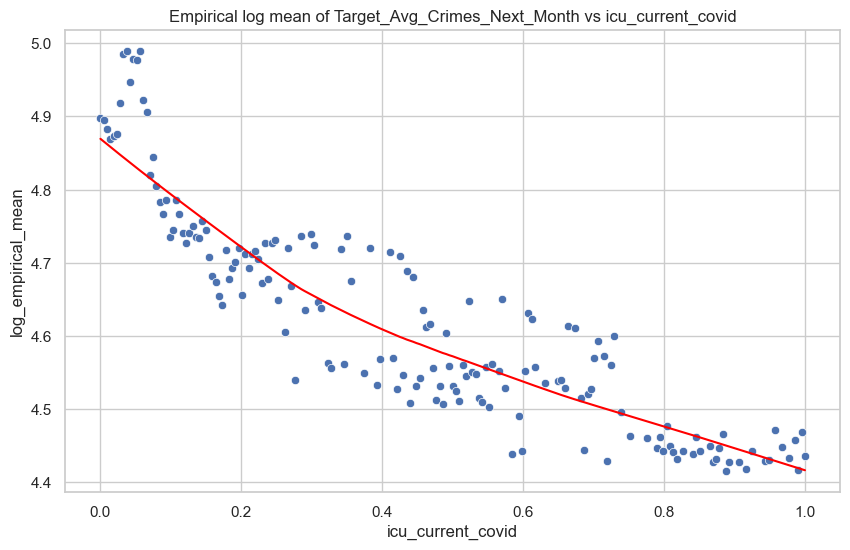

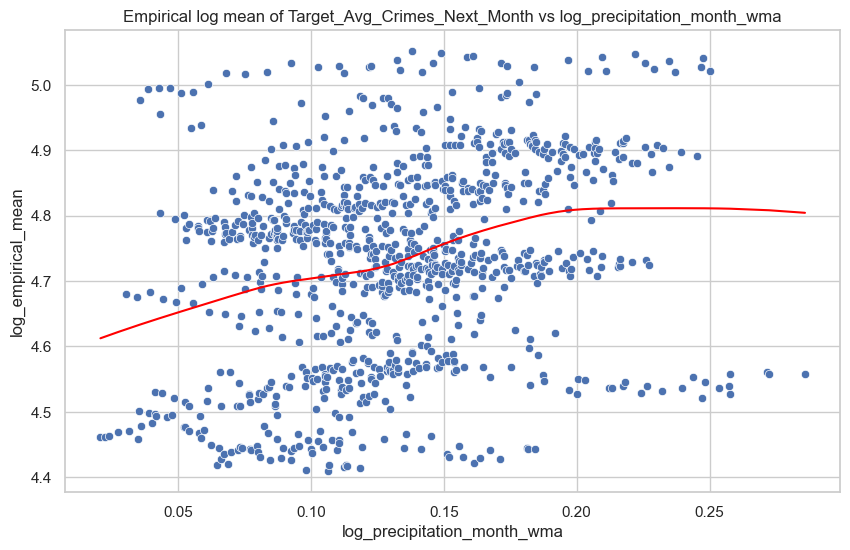

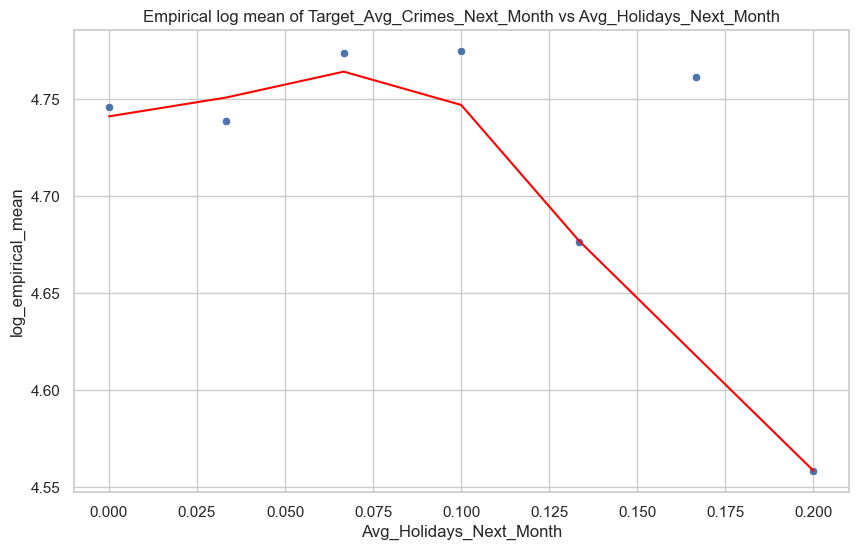

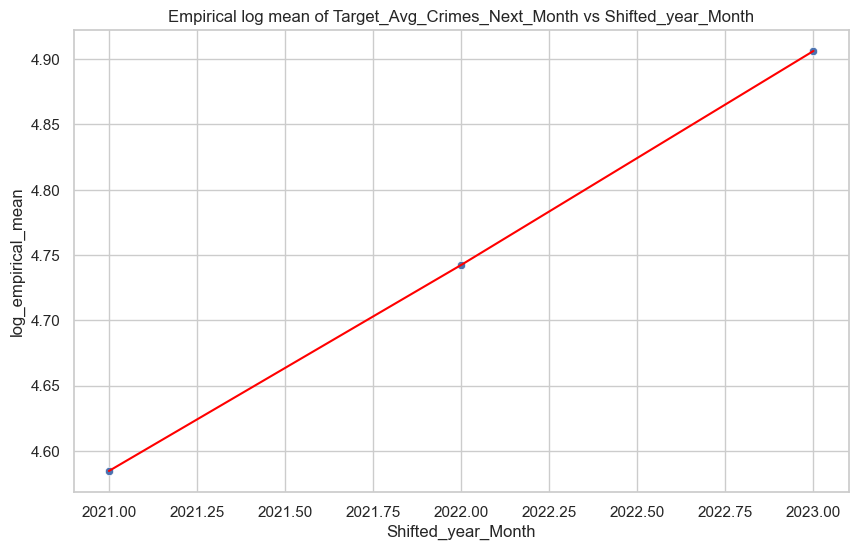

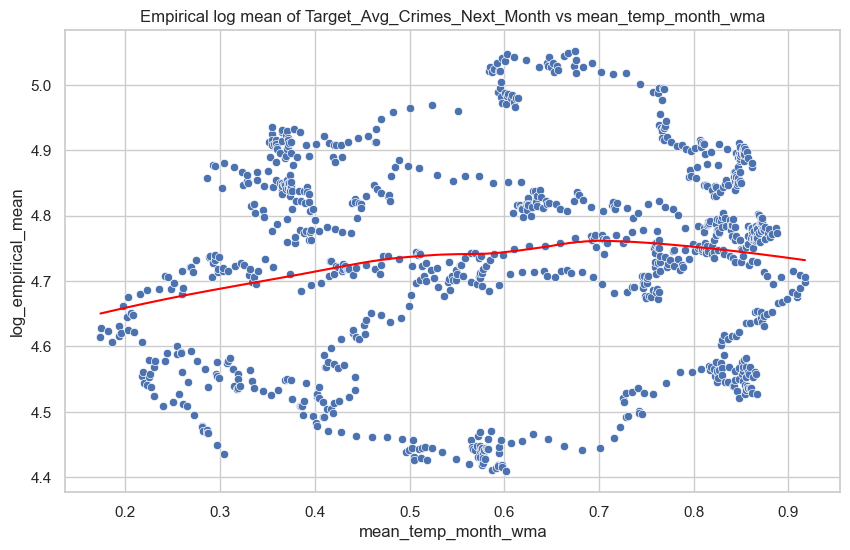

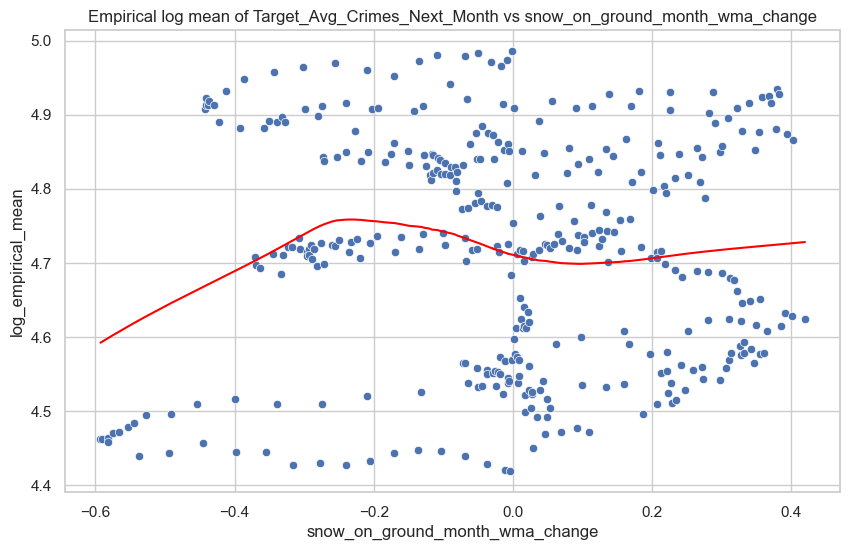

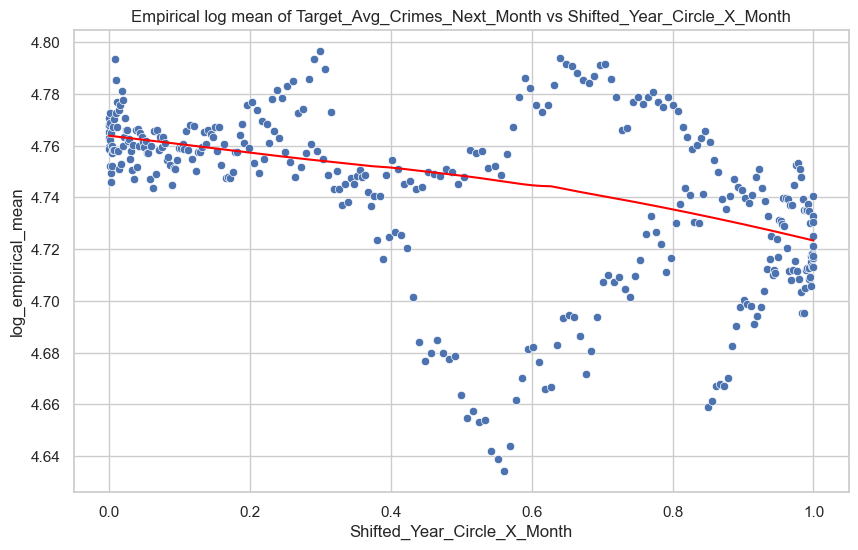

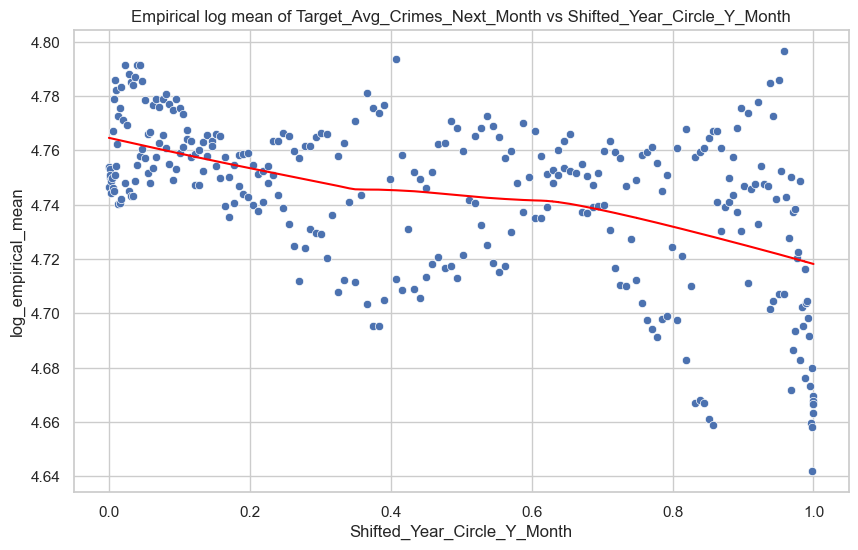

In [47]:
# List of significant and marginally significant variables
significant_vars = [
    'icu_current_covid', 'log_precipitation_month_wma', 'Avg_Holidays_Next_Month', 'Shifted_year_Month',
    'mean_temp_month_wma', 'snow_on_ground_month_wma_change', 'Shifted_Year_Circle_X_Month', 'Shifted_Year_Circle_Y_Month'
]


for var in significant_vars:
    # Group by the variable and compute the empirical mean
    grouped = df_month_labeled.groupby(var)['Target_Avg_Crimes_Next_Month'].mean().reset_index()
    
    # Take the log of the empirical means
    grouped['log_empirical_mean'] = np.log(grouped['Target_Avg_Crimes_Next_Month'])
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=var, y='log_empirical_mean', data=grouped)
    
    # Perform lowess smoothing
    smoothed = lowess(grouped['log_empirical_mean'], grouped[var])
    plt.plot(smoothed[:, 0], smoothed[:, 1], color='red')  # Add smoothed line to plot
    
    plt.title(f'Empirical log mean of Target_Avg_Crimes_Next_Month vs {var}')
    plt.show()


#### Adding Squared Features for Linearization

We introduce squared features for some variables. This is done to linearize the relationship between the log of the empirical mean of the target variable (`Target_Avg_Crimes_Next_Month`) and these features.

In [48]:
# Create new features that is the square of Avg_Holidays_Next_Month

df_all_crimes_per_day['Avg_Holidays_Next_Month_Squared'] = df_all_crimes_per_day['Avg_Holidays_Next_Month'] ** 2
df_all_crimes_per_day['mean_temp_month_wma_Squared'] = df_all_crimes_per_day['mean_temp_month_wma'] ** 2
df_all_crimes_per_day['Shifted_Year_Circle_Y_Month_Squared'] = df_all_crimes_per_day['Shifted_Year_Circle_Y_Month'] ** 2
df_all_crimes_per_day['snow_on_ground_month_wma_change_Squared'] = df_all_crimes_per_day['snow_on_ground_month_wma_change'] ** 2
df_all_crimes_per_day['Shifted_Year_Circle_X_Month_Squared'] = df_all_crimes_per_day['Shifted_Year_Circle_X_Month'] ** 2
month_columns.extend(['snow_on_ground_month_wma_change_Squared', 'Shifted_Year_Circle_X_Month_Squared'])

# Create DataFrame for training and DataFrame for future month predictions
df_month_labeled = df_all_crimes_per_day[month_columns].iloc[29:-(30+30+15)]
df_month_future = df_all_crimes_per_day[month_columns].iloc[-(30+30+15):-30]


# Train-Test split
train_data_month, test_data_month = train_test_split(df_month_labeled, test_size=0.2, shuffle=False)
target_column = 'Target_Avg_Crimes_Next_Month'
X_train = train_data_month.drop(columns=[target_column, 'date'])
y_train = train_data_month[target_column]
X_test = test_data_month.drop(columns=[target_column, 'date'])
y_test = test_data_month[target_column]

X_forcast = df_month_future.drop(columns=[target_column, 'date'])
    

In [49]:
for district, df in df_crimes_per_dist.items():
    df['Avg_Holidays_Next_Month_Squared'] = df['Avg_Holidays_Next_Month'] ** 2
    df['mean_temp_month_wma_Squared'] = df['mean_temp_month_wma'] ** 2
    df['Shifted_Year_Circle_Y_Month_Squared'] = df['Shifted_Year_Circle_Y_Month'] ** 2
    df['snow_on_ground_month_wma_change_Squared'] = df['snow_on_ground_month_wma_change'] ** 2
    df['Shifted_Year_Circle_X_Month_Squared'] = df['Shifted_Year_Circle_X_Month'] ** 2

    # Create DataFrame for training and DataFrame for future month predictions
    df_month_labeled_per_dist[district] = df[month_columns].iloc[29:-(30+30+15)]
    df_month_future_per_dist[district] = df[month_columns].iloc[-(30+30+15):-30]

    # Train-Test split
    train_data_month_per_dist[district], test_data_month_per_dist[district] = train_test_split(df_month_labeled_per_dist[district], test_size=0.2, shuffle=False)
    target_column = 'Target_Avg_Crimes_Next_Month'
    X_train_per_dist[district] = train_data_month_per_dist[district].drop(columns=[target_column, 'date'])
    y_train_per_dist[district] = train_data_month_per_dist[district][target_column]
    X_test_per_dist[district] = test_data_month_per_dist[district].drop(columns=[target_column, 'date'])
    y_test_per_dist[district] = test_data_month_per_dist[district][target_column]
    
    X_forcast_per_dist[district] = df_month_future_per_dist[district].drop(columns=[target_column, 'date'])

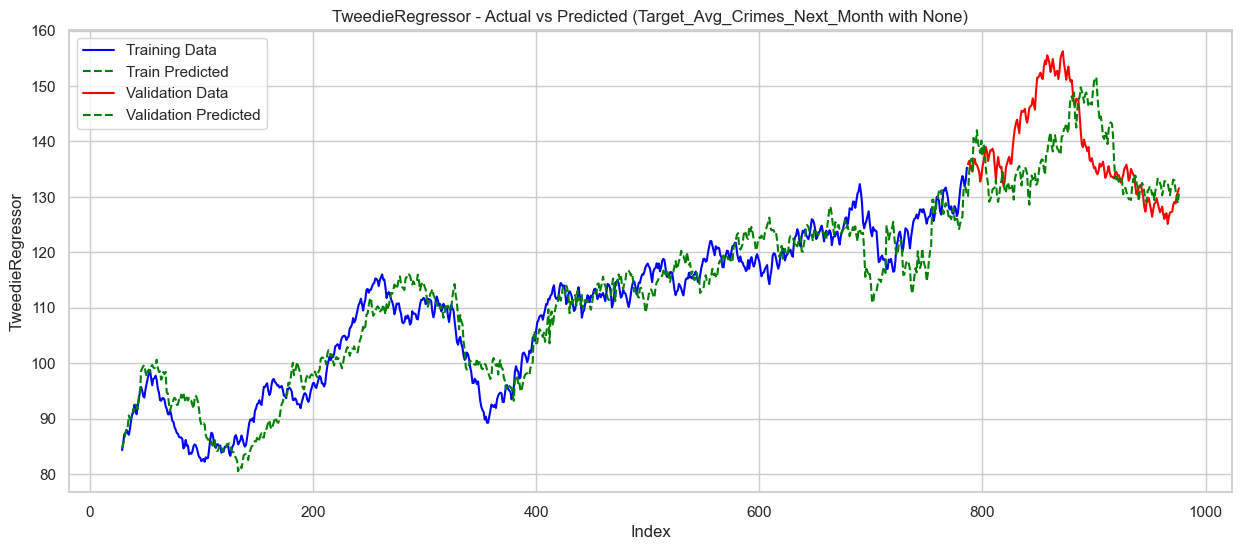

73.64550013178494


In [50]:
# Train the Poisson Regression model with default iterations (max_iter=1000) on the training set
glm_poisson_model = TweedieRegressor(power=1, alpha=0.01, max_iter=1000)  # Poisson distribution

mse, y_train_preds, y_test_pred = train_and_plot_model(X_train, y_train, X_test, y_test, glm_poisson_model)

print(mse)

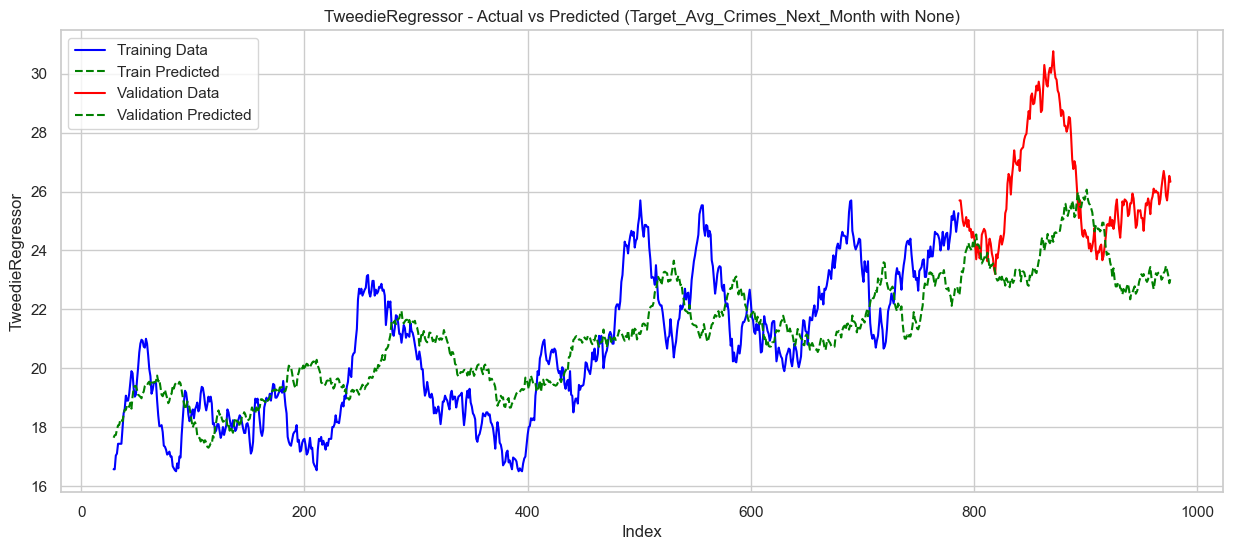

District 1 :  9.43332726459389


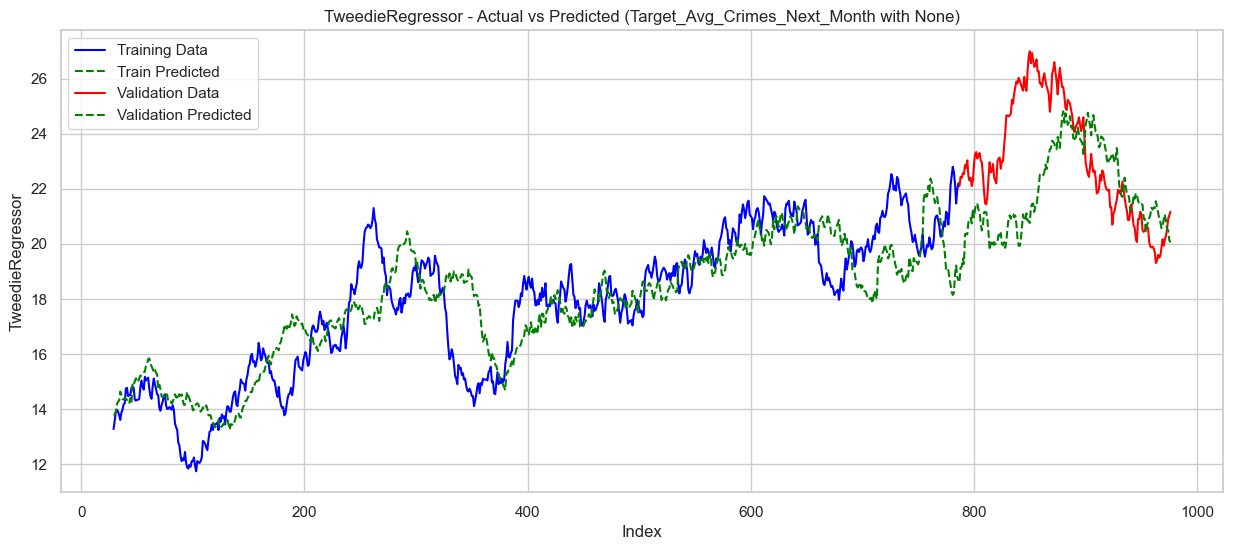

District 2 :  6.7343980386447715


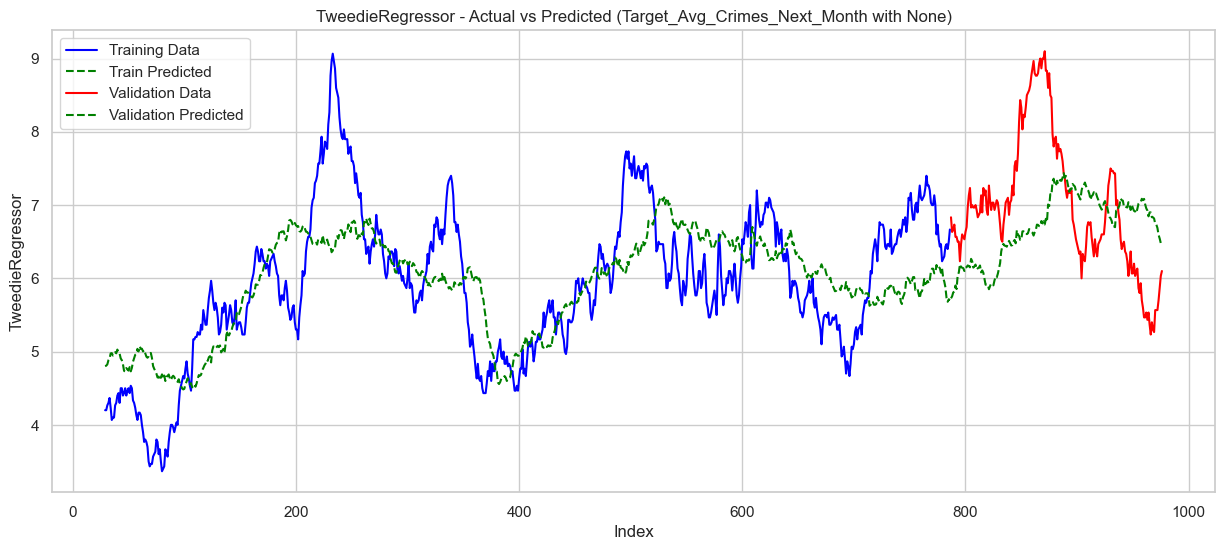

District 3 :  1.162742587292294


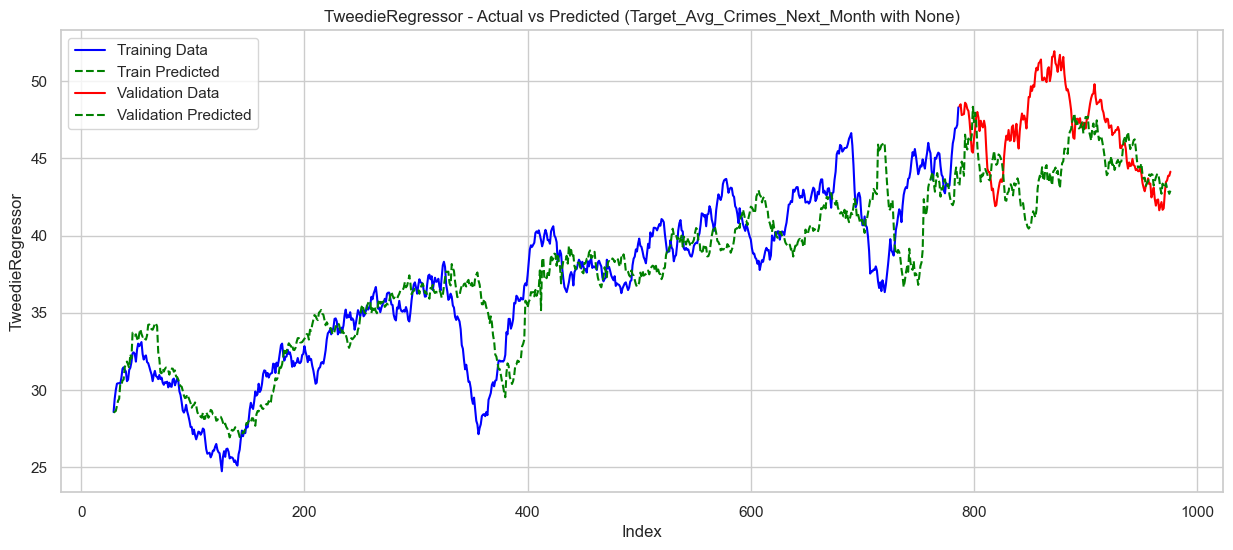

District 4 :  14.561621261642234


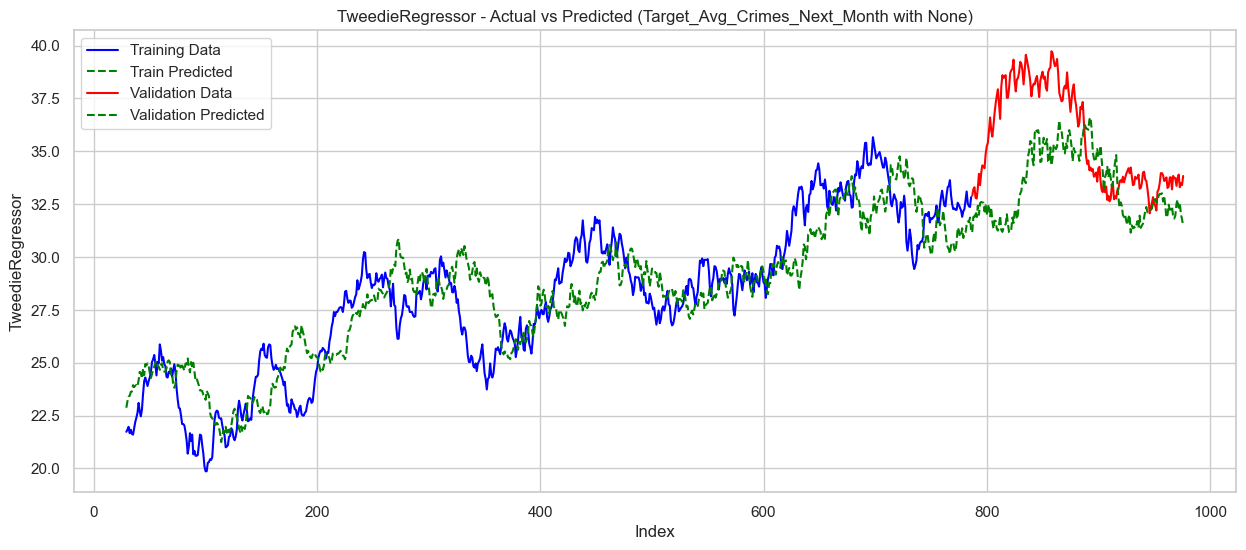

District 5 :  10.392858593995546


In [51]:
for district in df_crimes_per_dist.keys():
    glm_poisson_model = TweedieRegressor(power=2, alpha=0.01, max_iter=100)
    mse, y_train_preds, y_test_pred = train_and_plot_model(X_train_per_dist[district],
                                                           y_train_per_dist[district],
                                                           X_test_per_dist[district],
                                                           y_test_per_dist[district],
                                                           glm_poisson_model
                                                          )
    print(district,': ', mse)

In [52]:
X_train = df_month_labeled.drop(columns=[target_column, 'date'])
y_train = df_month_labeled[target_column]

X_train_per_dist, y_train_per_dist = {}, {}
for district, df in df_month_labeled_per_dist.items():
    X_train_per_dist[district] = df.drop(columns=[target_column, 'date'])
    y_train_per_dist[district] = df[target_column]

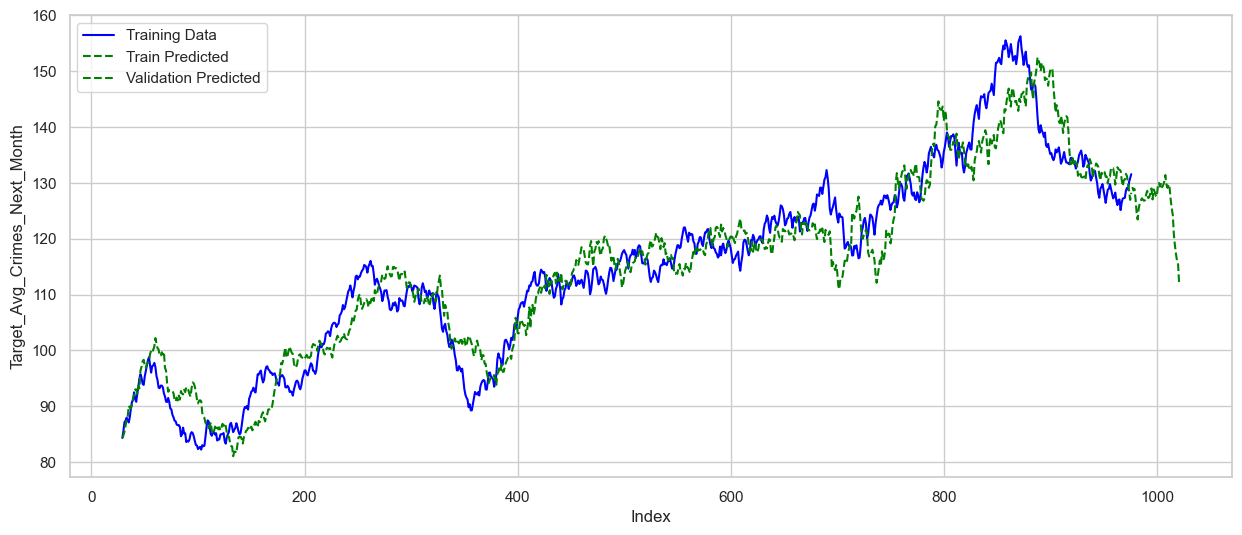

In [53]:
# Train the model and make predictions
glm_poisson_model = TweedieRegressor(power=1, alpha=0.01, max_iter=1000)  # Poisson distribution
glm_poisson_model.fit(X_train, y_train)
y_train_pred = glm_poisson_model.predict(X_train)
y_future_pred = glm_poisson_model.predict(X_forcast)

# Plot
plt.figure(figsize=(15, 6))
plt.plot(y_train.index, y_train, label='Training Data', color='blue')
plt.plot(y_train.index, y_train_pred, label='Train Predicted', color='green', linestyle='--')  # Note the variable name
plt.plot(X_forcast.index, y_future_pred, label='Validation Predicted', color='green', linestyle='--')
plt.xlabel('Index')
plt.ylabel(target_column)
plt.legend()
plt.show()

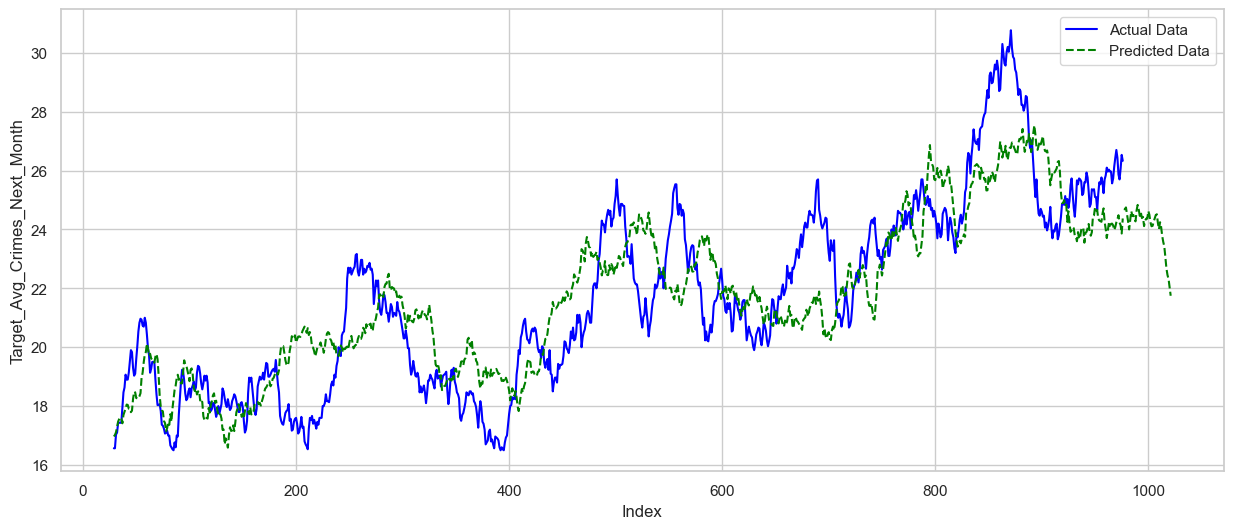

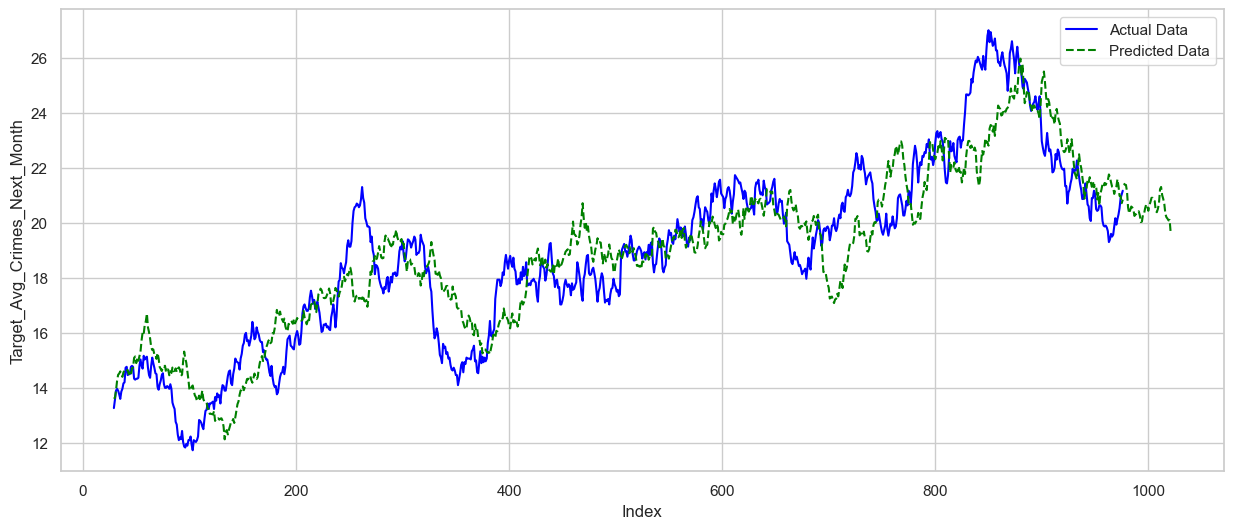

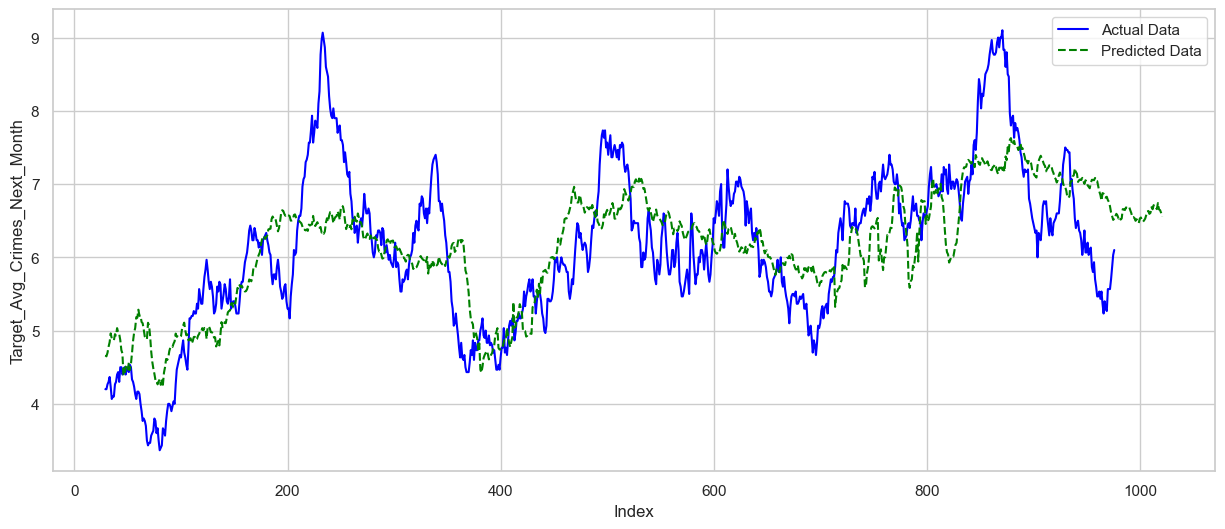

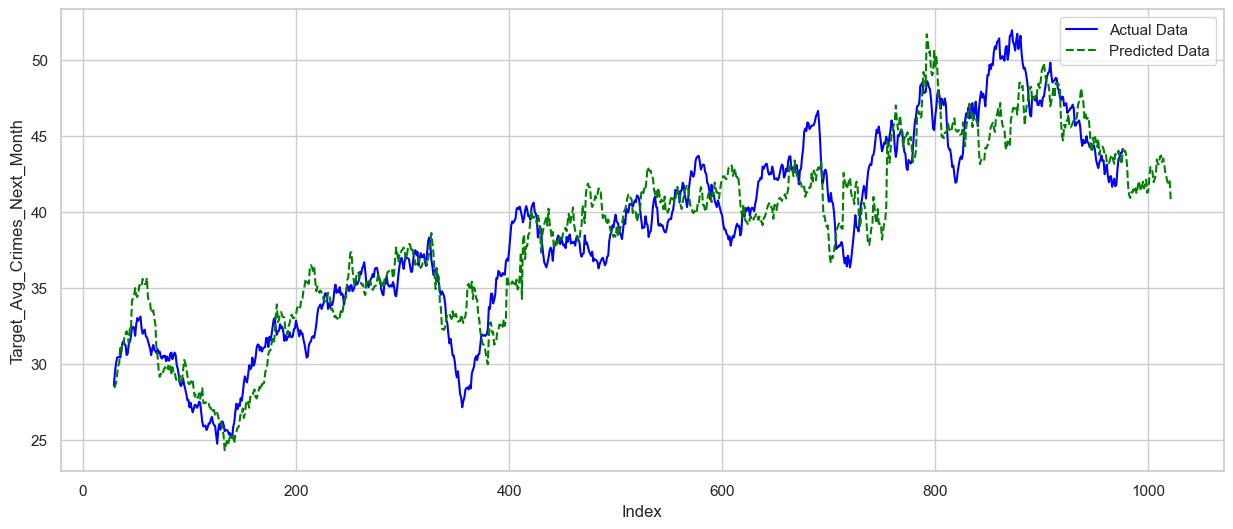

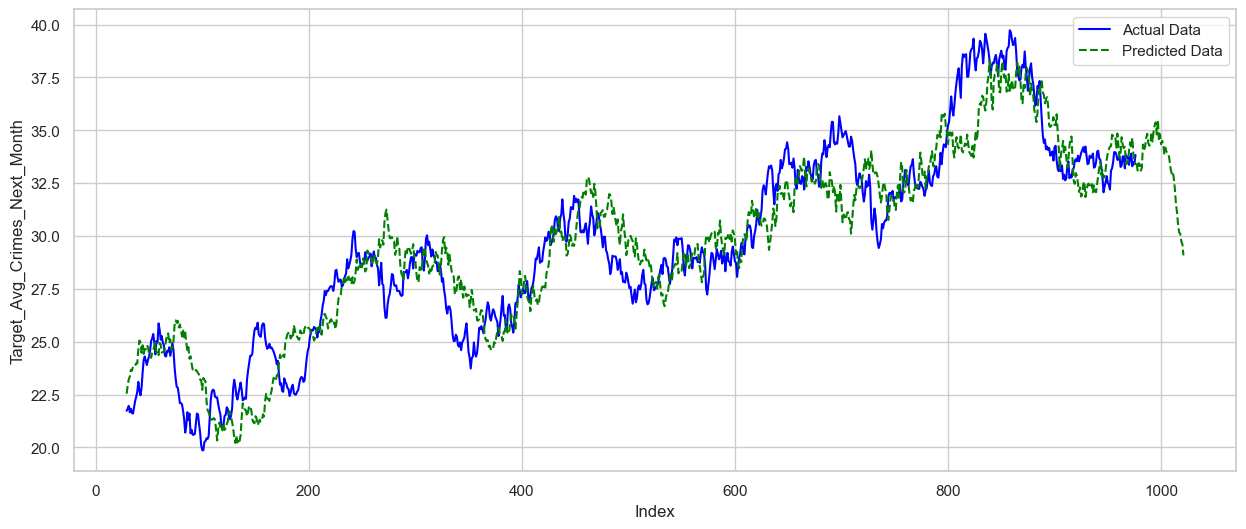

{'District 1': '-10.769965793569085 %',
 'District 2': '-5.794497650460421 %',
 'District 3': '0.3929948024402103 %',
 'District 4': '-7.453943165900252 %',
 'District 5': '-12.837988979660993 %'}

In [54]:
district_one_month_rate_percent = {}
for district in df_crimes_per_dist.keys():
    # Train the model and make predictions
    glm_poisson_model = TweedieRegressor(power=1, alpha=0.01, max_iter=1000)  # Poisson distribution
    glm_poisson_model.fit(X_train_per_dist[district], y_train_per_dist[district])
    y_train_pred = glm_poisson_model.predict(X_train_per_dist[district])
    y_future_pred = glm_poisson_model.predict(X_forcast_per_dist[district])
    district_one_month_rate_percent[district] = str(((y_future_pred[-1] - y_train_pred[-1])/y_train_pred[-1]) * 100) + ' %'

    # Plot
    plt.figure(figsize=(15, 6))
    plt.plot(y_train_per_dist[district].index, y_train_per_dist[district], label='Actual Data', color='blue')
    plt.plot(y_train_per_dist[district].index, y_train_pred, color='green', linestyle='--')  # Note the variable name
    plt.plot(X_forcast_per_dist[district].index, y_future_pred, label='Predicted Data', color='green', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel(target_column)
    plt.legend()
    plt.show()
district_one_month_rate_percent

### Interpretation of Poisson Regression Results

The Poisson Regression model predicts a decrease in the average rate of crimes for the upcoming month across all of York Region. This result can be valuable for law enforcement agencies, policymakers, and community leaders as it provides a data-driven basis for expecting a reduction in criminal activity.

#### Policy Implications:
1. **Resource Allocation**: Given the predicted decrease, law enforcement agencies might consider reallocating resources to other pressing needs or focusing on proactive policing strategies.
  
2. **Community Engagement**: This could be a good time for community outreach programs aiming to sustain and further reduce the crime rate.

3. **Evaluation of Past Measures**: The predicted decrease could also indicate that previous crime prevention measures are effective, warranting a closer look to understand what has been working well.

4. **Caution**: While the model predicts a decrease, it's important to maintain vigilance and not become complacent, as external factors not captured by the model could influence crime rates.

#### Note:
These interpretations are based on the assumption that the model is well-calibrated and has considered all relevant features. Always remember that predictions are subject to uncertainties and should be used in conjunction with expert judgment.

## Task 2

### Exceptions Dataset

In [55]:
# Load the '4 District Platoon Staffing Exceptions 2020 to 2022' dataset
staffing_filepath = 'Downloads/4 District Platoon Staffing Exceptions 2020 to 2022.xlsx'
staffing_df = pd.read_excel(staffing_filepath)

# Show the first few rows of the dataset to understand its structure
staffing_df.head()

Platoon  Officer Badge #  Exception Date Exception Start Time  \
0  4 District B Platoon            34260        20200227             07:00:00   
1  4 District B Platoon            34260        20200220             07:00:00   
2  4 District B Platoon            34260        20200219             07:00:00   
3  4 District B Platoon            34260        20200307             07:00:00   
4  4 District B Platoon            34260        20200228             07:00:00   

   # of Hours Exception Type  
0        12.0       Vacation  
1        10.0       Training  
2        10.0       Training  
3        12.0           Sick  
4        12.0       Vacation

In [56]:
staffing_df.drop(columns={'Platoon', 'Officer Badge #'}, inplace=True)

In [57]:
# Data Cleaning and Transformation for '4 District Platoon Staffing Exceptions 2020 to 2022'

# Convert 'Exception Date' to datetime format
staffing_df['Date'] = pd.to_datetime(staffing_df['Exception Date'], format='%Y%m%d')
staffing_df.drop(columns={'Exception Date'}, inplace=True)

# Check for missing values in the staffing exceptions dataset
staffing_missing = staffing_df.isnull().sum()

staffing_missing

Exception Start Time    0
# of Hours              0
Exception Type          0
Date                    0
dtype: int64

In [58]:
# Create a new DataFrame to aggregate the sum of hours by date
exceptions_by_date_df = staffing_df.groupby('Date')['# of Hours'].sum().reset_index(name='Total Exception Hours')

# Generate Ontario holidays for the years covered in the dataset
ontario_holidays = holidays.Canada(years=np.unique(exceptions_by_date_df['Date'].dt.year), prov='ON')

# Add a column to the DataFrame to indicate if the exception date is an Ontario holiday
exceptions_by_date_df['Is Holiday'] = exceptions_by_date_df['Date'].apply(lambda x: x in ontario_holidays)

# Create new columns for various date components
exceptions_by_date_df['Week'] = exceptions_by_date_df['Date'].dt.isocalendar().week
exceptions_by_date_df['Month'] = exceptions_by_date_df['Date'].dt.month
exceptions_by_date_df['Weekday'] = exceptions_by_date_df['Date'].dt.weekday
exceptions_by_date_df['Day'] = exceptions_by_date_df['Date'].dt.day

# Sort the DataFrame by date
exceptions_by_date_df = exceptions_by_date_df.sort_values('Date')


In [59]:
exceptions_by_date_df.head()

Date  Total Exception Hours  Is Holiday  Week  Month  Weekday  Day
0 2020-01-01                  298.5        True     1      1        2    1
1 2020-01-02                  191.0       False     1      1        3    2
2 2020-01-03                  213.0       False     1      1        4    3
3 2020-01-04                   98.0       False     1      1        5    4
4 2020-01-05                  178.0       False     1      1        6    5

### Calls Dataset

In [60]:
# Load the 'Calls for Service 2020-2022' dataset
calls_for_service_filepath = 'Downloads/Calls for Service 2020-2022.xlsx'
calls_df = pd.read_excel(calls_for_service_filepath)

calls_df.head()

Call Date Call Time (HH:MM:SS) District Sector            Call Type
0   20200101             00:05:46        2     21      UNKNOWN TROUBLE
1   20200101             02:06:01        4     44  ASSAULT IN PROGRESS
2   20200101             00:37:32        5     55                 FIRE
3   20200101             01:41:30        5     55        CHECK WELFARE
4   20200101             00:46:26        1     13    DOMESTIC VIOLENCE

In [61]:
# Data Cleaning and Transformation for 'Calls for Service 2020-2022'

calls_df = calls_df[calls_df['District']==4]

# Convert 'Call Date' to datetime format
calls_df['Date'] = pd.to_datetime(calls_df['Call Date'], format='%Y%m%d')
calls_df.drop(columns={'Call Date'}, inplace=True)

# Check for missing values in the calls for service dataset
calls_for_service_missing = calls_df.isnull().sum()

calls_for_service_missing

Call Time (HH:MM:SS)    0
District                0
Sector                  0
Call Type               8
Date                    0
dtype: int64

In [62]:
calls_by_date_df = calls_df.groupby('Date').size().reset_index(name='Number of Calls')
calls_by_date_df.head()

Date  Number of Calls
0 2020-01-01               75
1 2020-01-02               82
2 2020-01-03               89
3 2020-01-04               78
4 2020-01-05               77

In [63]:
exceptions_calls_df = pd.merge(calls_by_date_df, exceptions_by_date_df, on='Date', how='inner')

### Crimes Dataset

In [64]:
# Load the dataset
file_path = 'Downloads/Year_to_Date_Community_Safety_Data_.csv'
crimes_df = pd.read_csv(file_path)

# Convert 'rep_date' to datetime format, remove time zone info, and keep only the date part
crimes_df['Date'] = pd.to_datetime(crimes_df['rep_date']).dt.tz_convert(None).dt.normalize()

# Group by 'date' and 'municipality' to count the number of crimes
crimes_df = crimes_df.groupby('Date').size().reset_index(name='Number of Crimes')

# Fill NaN values in 'Number_of_Crimes' with 0
crimes_df['Number of Crimes'].fillna(0, inplace=True)

# Display the head of the merged DataFrame
exceptions_calls_crimes_df = pd.merge(exceptions_calls_df, crimes_df, on='Date', how='left')

exceptions_calls_crimes_df.head()

Date  Number of Calls  Total Exception Hours  Is Holiday  Week  Month  \
0 2020-01-01               75                  298.5        True     1      1   
1 2020-01-02               82                  191.0       False     1      1   
2 2020-01-03               89                  213.0       False     1      1   
3 2020-01-04               78                   98.0       False     1      1   
4 2020-01-05               77                  178.0       False     1      1   

   Weekday  Day  Number of Crimes  
0        2    1               NaN  
1        3    2               NaN  
2        4    3               NaN  
3        5    4               NaN  
4        6    5               NaN

### Visualization

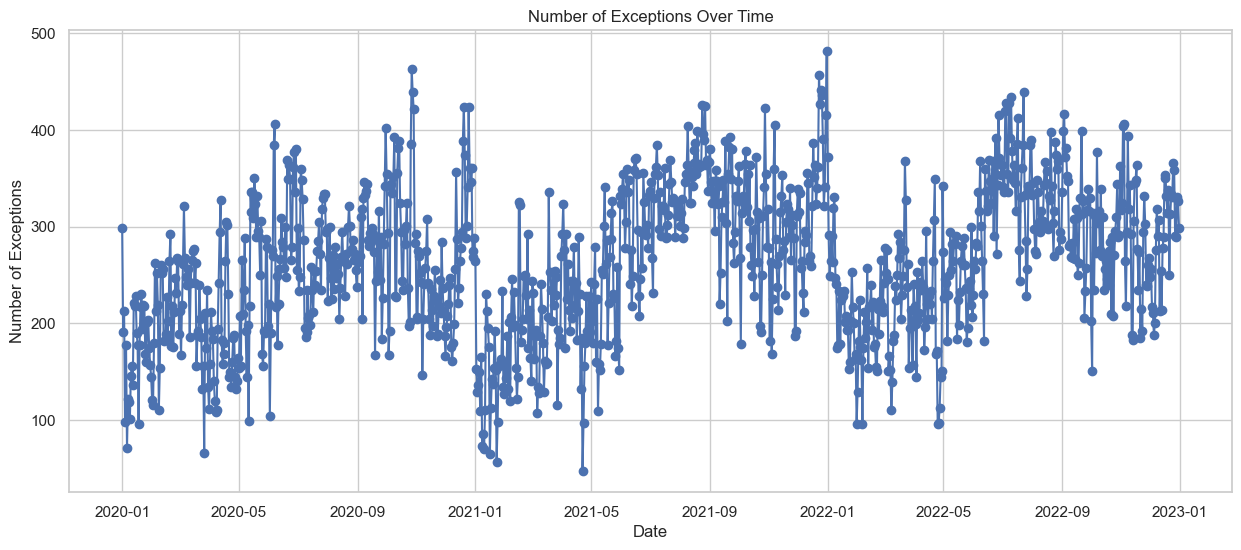

In [65]:
# Plot the number of exceptions over time
plt.figure(figsize=(15, 6))
plt.plot(exceptions_calls_crimes_df['Date'], exceptions_calls_crimes_df['Total Exception Hours'], marker='o')
plt.xlabel('Date')
plt.ylabel('Number of Exceptions')
plt.title('Number of Exceptions Over Time')
plt.grid(True)
plt.show()

In [66]:
print(exceptions_calls_crimes_df.head())

        Date  Number of Calls  Total Exception Hours  Is Holiday  Week  Month  \
0 2020-01-01               75                  298.5        True     1      1   
1 2020-01-02               82                  191.0       False     1      1   
2 2020-01-03               89                  213.0       False     1      1   
3 2020-01-04               78                   98.0       False     1      1   
4 2020-01-05               77                  178.0       False     1      1   

   Weekday  Day  Number of Crimes  
0        2    1               NaN  
1        3    2               NaN  
2        4    3               NaN  
3        5    4               NaN  
4        6    5               NaN  


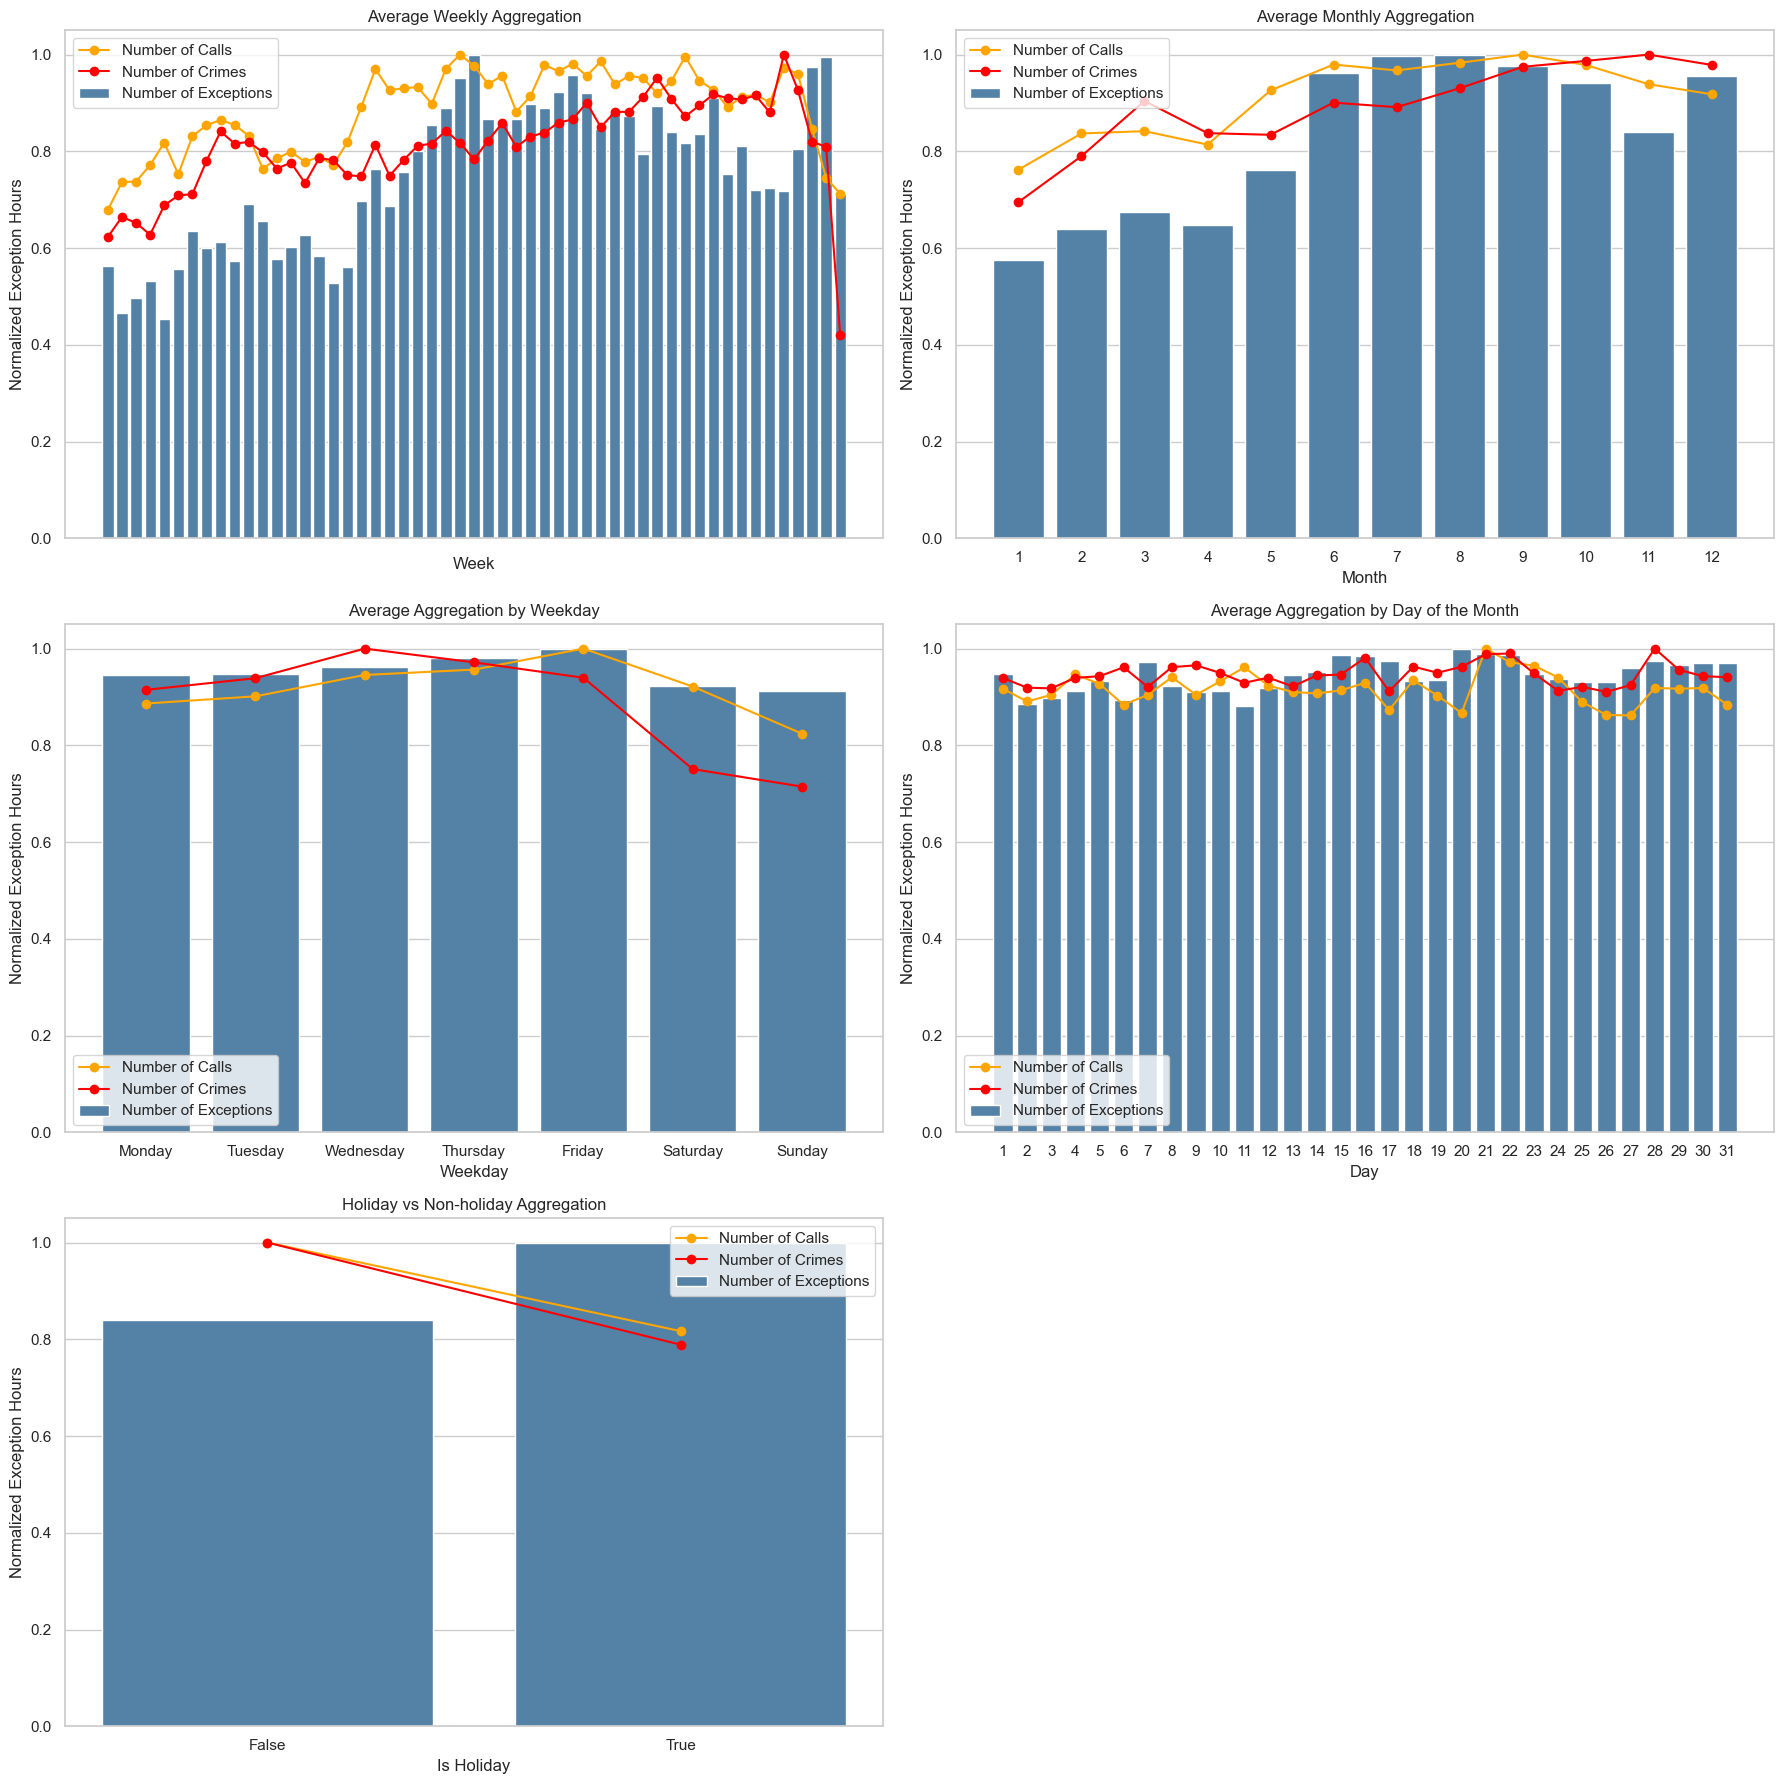

In [67]:
# Function to normalize a Pandas Series
def normalize_series(s):
    return s / s.max()

# Create new subplots with updated styling
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

# Function to adjust lineplot x-coordinates to align with barplot
def adjust_lineplot(ax, line_y, color, label):
    line_x = [p.get_x() + p.get_width() / 2. for p in ax.patches]
    ax.plot(line_x, line_y, color=color, marker='o', label=label)

# Iterate through the axes to generate each plot
for i, (agg_col, title) in enumerate(zip(['Week', 'Month', 'Weekday', 'Day', 'Is Holiday'], 
                                         ['Average Weekly Aggregation', 'Average Monthly Aggregation', 'Average Aggregation by Weekday',
                                          'Average Aggregation by Day of the Month', 'Holiday vs Non-holiday Aggregation'])):
    
    row = i // 2
    col = i % 2

    aggregated_df = exceptions_calls_crimes_df.groupby(agg_col).mean().reset_index()
    
    # Normalize the aggregated data
    aggregated_df['Normalized Exception Hours'] = normalize_series(aggregated_df['Total Exception Hours'])
    aggregated_df['Normalized Calls'] = normalize_series(aggregated_df['Number of Calls'])
    aggregated_df['Normalized Crimes'] = normalize_series(aggregated_df['Number of Crimes'])

    # Plot the bars
    ax = axes[row, col]
    sns.barplot(x=agg_col, y='Normalized Exception Hours', data=aggregated_df, ax=ax, ci=None, color='steelblue', label='Number of Exceptions')
    
    # Plot the lineplots
    adjust_lineplot(ax, aggregated_df['Normalized Calls'], 'orange', 'Number of Calls')
    adjust_lineplot(ax, aggregated_df['Normalized Crimes'], 'red', 'Number of Crimes')
    
    ax.set_title(title)
    ax.legend()
    
    if i == 0:
        ax.set_xticklabels([])
    
    if i == 2:
        ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Remove unused subplot
fig.delaxes(axes[2,1])
plt.tight_layout()
plt.show()

**Analysis of Scheduling Challenges in 4 District**

1. **Average Weekly and Monthly Aggregation**:
   - From June to the end of the year, there's a noticeable increase in exceptions, possibly due to the warmer weather in Canada. Simultaneously, there's a rise in the number of calls, indicating a potential need for more officers during these months.
   
2. **Average Aggregation by Weekday**:
   - Fridays experience the highest number of officer offs and also record the most calls, highlighting a significant challenge for resource allocation on this day.

3. **Average Aggregation by Day of the Month**:
   - No distinct trend is apparent in this aggregation, suggesting a consistent distribution of calls and exceptions throughout the month.
   
4. **Holiday vs Non-holiday Aggregation**:
   - Although holidays record fewer calls than non-holidays, the number of exceptions is notably higher. This implies that more officers might be taking holidays off. Fortunately, the demand for calls is reduced during these times.

**Key Takeaways**:
- Resource allocation and scheduling might face challenges during warmer months plus December when both calls and exceptions are high.
- Fridays stand out as particularly challenging, with a high number of officer offs coinciding with increased call demand. Ensuring adequate staffing on Fridays will be critical to address these challenges.
- Although holidays see fewer calls, the higher number of exceptions indicates a need for strategic scheduling.

**Conclusion**:
Effective planning and anticipation of resource requirements are essential, particularly during warmer months, on Fridays, and in December, to maintain a consistent and efficient response to calls in 4 District. Please note that to accurately assess the situation, it's crucial to have data on the total number of officers working each day, as there might be fewer officers available from the outset.